## Problem Statement

The goal of this case study is to predict the conversion rate (C2B), which is the ratio of bookings to clickouts, for hotel-advertiser combinations on trivago's website. 
We have information about the characteristics of each hotel, as well as the number of clickouts and bookings per hotel-advertiser pair over a 10-day period from August 1, 2023, to August 10, 2023. 
The prediction target is the conversion rate for August 11, 2023.
The data is provided in two datasets: `hotels` and `metrics`.
Among the main challenges are the zero-inflated characteristic of the number of bookings and clickouts, as well as the high proportion of unobserved data samples within the 10-day interval.


## Tasks
1. **Explore the Data**: Examine the provided datasets to understand characteristics and anomalies of the data, and to identify relevant patterns for the conversion rate prediction problem.
2. **Predict Conversion Rate**: Discuss potential solutions for predicting the conversion rate. Implement one of such solutions, evaluate the prediction performance, and present the results.


## Answer to Task 1

### Key findings observed through the Exploratory Data Analysis

1. **Zero-Inflation**: Around 80% of click and booking data is zero, indicating a high degree of zero inflation. The zero inflation appears not to be related to specific values of other variables, such as the number of stars or the city of the hotel. The zero inflation causes the discussed variables and the derived target (c2b of the following day) to be highly skewed, which complicates the solution of the problem.
2. **Missing Data**: Around 50% of the samples are unobserved, meaning that the number of bookings and clickouts for a certain hotel-advertiser combination may not be available for all the dates in the studied period. These missing values are not concentrated on specific days, hotels, or advertisers. The high proportion of unobserved samples constitutes a significant challenge for model training and evaluation. 
3. **Nan Values**: There are only two NaN values present in the dataset, both associated with the `rating` and `n_reviews` of a specific hotel. These can be addressed using simple group-wise imputation techniques to fill in the missing values.
4. **Seasonal Trend**: A seasonal trend with a 5-day cadence is observed in the data, which needs to be considered in the model.

These observations guide the choice of imputation strategies, data transformation methods, learning models, and evaluation metrics for the prediction task.


## Answer to Task 2

### Potential Solutions for Setting Up the Regression Problem

The problem is approached as a regression task where data from one day, along with historical features from a specific number of previous days, is used to predict the conversion rate of the following day. This requires a combination of imputation of missing values, extraction of historical features, and corresponding splitting of the data into training, development, and test sets.

**Possible Approaches:**

**Method 1**: Impute missing data, extract features for each hotel_id, advertiser_id, and date (ymd), then split the data into training, development, and test sets based on specific dates. Validation data for hyperparemter optimization is derived from the training set through k-fold cross-validation.
- **Option 1a**: Use a up-to-7-day lookback window. Use a 7-day lookback window. Train on August 8 data (predict August 9), develop on August 9 data (predict August 10), and test on August 10 data (predict August 11).
- **Option 1b**: Use a up-to-5-day lookback window to capture the main seasonal cycle. Train on August 6-8 data, develop on August 9, and test on August 10.

**Method 2**: Impute data only for August 10 and use flexible historical features (such as rolling window features that ignore NaN values) with up-to-5-days lookback window. Train on available samples from August 6-8, develop on August 9, and test on August 10. Validation data for hyperparemter optimization is derived from the training set through k-fold cross-validation.

**Chosen Solution**: I pursued option 1a in lieu of its simplicity and equivalent performance to option 1b. In hindsight, I believe that option 2 may have greater potential for its lower reliance on data imputation. 

### Chosen Imputation Techniques

- **For Nan Values**: Simple group-wise imputation based on related features.
- **For Unobserved Samples**: Create samples for any missing combinations of `hotel_id`, `advertiser_id`, and `ymd` (date). For each newly created sample, copy the static characteristics of the hotel, such as `stars`, `city_id`, `rating`, and `n_reviews`, which do not change over time period under exam. For the dynamically changing values, such as n_bookings and n_clickouts, use the KNN imputation method. Special care is taken in choosing the KNN parameters to limit further zero-inflation of the imputed values. K=2 and distance-weighted averaging are used to favour the detection of local patterns over smoothed values that would most likely be zero or close to zero.

### Chosen Data Transformation Techniques

For ease of interpretation, data transformations are only applied to non-zero-inflated variables to reduce their skewness. Positively-skewed `n_reviews` and negatively-skewed `rating` are transformed with simple logarithmic and square transformations.

### Chosen Features

Historical features were generated by calculating lagged values and rolling window statistics for conversion rates for each hotel-advertiser combination. Mean encodings were applied to capture the average conversion rates across different groups such as hotel, advertiser, city, and star ratings. A seasonal indicator based on days of the week has been included to capture periodic trends (although this would only be useful for strategies where samples from different days are used for training, such as 1b or 2).

### Chosen Learning Algorithm

- **LightGBM Regressor**: Chosen for its nonlinearity, robustness to heteroscedastic data, and ability to handle both numerical and unencoded categorical features. It also provides measures of feature importance.
- **Other Possible Options**: Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB) are often used for similar zero-inflated count prediction tasks. However, being unfamiliar with such techniques, I preferred the LightGBM Regressor.

### Model Evaluation Strategies

- **Evaluation Metrics**: Various metrics such as MAE, RMSE and a weighted sum of MAE and RMSE normalized to zero and non-zero values were considered. The MAE is favorable for interpretability in heteroschedastic contexts as it is equally influenced by small and large errors. The RMSE provides a better characterization of non-zero predictions by penalizing them. A weighted average of the normalized MAE and RMSE was also considered to balance the interpretability of the MAE with the sensitivity to large errors of the RMSE. Ultimately, MAE was selected as the primary scoring metric when used as the scoring function for hyperparameter optimization because of its interpretability and because it performed slightly better qualitatively on both the training and development sets.
- **Graphical Evaluation**: Model performance was also assessed using graphical methods. The scatterplot of predicted versus true target values was found to be the most informative, providing a clear visualization of prediction accuracy and error distribution. Additionally, overlayed line plots of predicted versus true target values were used to evaluate the alignment of predictions with actual values. Feature importance was evaluated using the number of splits in LightGBM, offering insights into the most influential features in the model. 

## Comment on the Results
- The main results of the analysis showed that the chosen regression model (LightGBM) achieved a mean absolute error (MAE) of 0.02 on the training set and 0.03 on the development set. The baseline performance using a Dummy Regressor with a mean strategy resulted in an MAE of 0.04. While the prediction performance exceeds the baseline, the current performance evaluation based on MAE might not fully capture the improvement observed in the graphical evaluation. MAE was chosen for its simplicity and interpretability, as it provided marginally better results than other more complex metrics in the graphical evaluation. However, it lacks the nuance to effectively interpret the improvements in the context of this specific problem, which includes significant zero-inflation and heteroscedasticity in the data.
- The chosen regression strategy ("Method 1a"), which involves imputing all the unobserved samples, exacerbates the zero-inflation problem in the data. The imputation method, based on KNN, tends to increase the number of zero values, despite being tuned to minimize this effect. This leads to a higher proportion of zero-inflated predictions, which might not accurately reflect the true distribution of the data.
- To address the zero-inflation problem more effectively, further investigations could involve trying a regression approach with minimal imputation (referred to as "Method 2" above), focusing only on the essential missing values. Additionally, exploring zero-inflated regression models such as Zero-Inflated Poisson (ZIP) or Zero-Inflated Negative Binomial (ZINB) could provide better performance for this type of data.

## Note on the Working Directory
To run this notebook, please adjust the path to the working directory below. The working directory should contain the notepad and the two data sets provided. The .csv file with the results will be saved in the same directory. 

In [1]:
# Install the necessary packages
!pip install numpy>=1.26.4 pandas>=2.2.2 matplotlib>=3.8.2 scipy>=1.13.0 seaborn>=0.13.2 scikit-learn>=1.4 bottleneck>=1.3.6

In [2]:
import os
from datetime import datetime

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import randint, loguniform, skew, ks_2samp, kurtosis
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, PredictionErrorDisplay
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler

C:\Users\gigli\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load Data

In [3]:
# >>> Adapt this: 
working_dir = "path/to/working/dir"  

In [4]:
# Load the provided datasets
hotels_df = pd.read_csv(os.path.join(working_dir, "hotels.csv"))
metrics_df = pd.read_csv(os.path.join(working_dir, "metrics.csv"))

## Data Inspection

The initial inspection of the dataset aims to achieve three main objectives: identifying unique sample identifiers, characterizing the columns' nature (discrete or continuous), and observing missing values.

- The column hotel_id serves as a unique identifier for each sample in the dataset, ensuring that each row represents a distinct hotel.
- Only one hotel has missing values `n_reviews` and `rating` column.
- The columns `n_reviews`, `rating`, `n_clickouts`, `n_bookings` represent numerical data, while `ymd`, `hotel_id`, `advertiser_id`, `city_id`, and `stars` are categorical identifiers.

In [5]:
# Setup print option for Pandas Dataframes 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [6]:
# Inspect the Datasets structure
print("DATASET 'HOTELS':")
display(hotels_df.head())
print(f"Shape: {hotels_df.shape}.\n")
print(f"{hotels_df.info(show_counts=True)}\n")
print(f"\nNumber of unique values: \n{hotels_df.nunique()}\n")
# print(f"Descriptive statistics of numerical columns:\n{hotels_df.describe()}\n")
print(f"Rows with missing data in 'hotels_df': \n{hotels_df.loc[hotels_df.isna().any(axis=1)]}\n")

DATASET 'HOTELS':


,hotel_id,stars,n_reviews,rating,city_id
0,1,3,3601.0,6.1,36
1,2,3,1949.0,8.6,36
2,3,2,899.0,6.8,71
3,4,3,3057.0,4.1,19
4,5,3,938.0,6.3,41


Shape: (224, 5).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hotel_id   224 non-null    int64  
 1   stars      224 non-null    int64  
 2   n_reviews  223 non-null    float64
 3   rating     223 non-null    float64
 4   city_id    224 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 8.9 KB
None


Number of unique values: 
hotel_id     224
stars          6
n_reviews    218
rating        45
city_id       86
dtype: int64

Rows with missing data in 'hotels_df': 
     hotel_id  stars  n_reviews  rating  city_id
215       216      0        NaN     NaN        3



In [7]:
print("DATASET 'METRICS':")
display(metrics_df.head())
print(f"Shape: {metrics_df.shape}.\n")
print(f"{metrics_df.info(show_counts=True)}\n")
print(f"\nNumber of unique values: \n{metrics_df.nunique()}\n")
# print(f"Descriptive statistics of numerical columns:\n{metrics_df.describe()}\n")

# Calculate the average number of advertiser_id per hotel_id
average_advertisers_per_hotel = metrics_df.groupby('hotel_id')['advertiser_id'].nunique().mean()
print(f"\nOn average, each hotel_id is associated with {average_advertisers_per_hotel:.2f} advertiser_id values.")

DATASET 'METRICS':


,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings
0,20230801,1,1,5,0
1,20230801,1,5,159,5
2,20230801,1,14,1,0
3,20230801,1,37,2,0
4,20230801,1,39,1,0


Shape: (10292, 5).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10292 entries, 0 to 10291
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ymd            10292 non-null  int64
 1   hotel_id       10292 non-null  int64
 2   advertiser_id  10292 non-null  int64
 3   n_clickouts    10292 non-null  int64
 4   n_bookings     10292 non-null  int64
dtypes: int64(5)
memory usage: 402.2 KB
None


Number of unique values: 
ymd               10
hotel_id         224
advertiser_id     43
n_clickouts      234
n_bookings        24
dtype: int64


On average, each hotel_id is associated with 9.11 advertiser_id values.


In [8]:
# Check correspondance of "hotel_id" in both DataFrames
hotels_ids = set(hotels_df['hotel_id'])
metrics_ids = set(metrics_df['hotel_id'])
print(f"Exact correspondence of the 'hotel_id' values in the two datasets: {hotels_ids == metrics_ids}.\n")

Exact correspondence of the 'hotel_id' values in the two datasets: True.



## Data Preprocessing

The two datasets are merged and the resulting rows and columns are sorted and reordered for ease of interpretation. Group-wise imputation of the nan values is performed. The conversion rate variable `c2b` is created. All data types are optimized for computational efficiency.

In [9]:
# Merge the hotels and metrics DataFrames on the "hotel_id" column.
data = pd.merge(hotels_df, metrics_df, on="hotel_id", how="inner")

# Sort rows and reorder columns for ease of evaluation
data = data.sort_values(by=["hotel_id", "advertiser_id", "ymd"]).reset_index(drop=True)
data = data[['ymd', 'hotel_id', 'advertiser_id', 'city_id', 'stars', 'rating', 'n_reviews', 'n_clickouts', 'n_bookings']]

In [10]:
# Create conversion rate variable c2b
data["c2b"] = data["n_bookings"] / data["n_clickouts"]

Assess the duability of group-wise imputation for `rating` and `n_reviews` based on their mutual information wrt the other columns of the dataset. Group-wise imputation wrt the values of the variable `city_id` is performed because such variable shares considerable mutual information with the the variables with missing values, at least one order of magnitude larger than all the other variables. 

In [11]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
for target_feature in ["rating", "n_reviews"]:
    features = ["city_id", "stars", "n_clickouts", "n_bookings"]
    selector.fit(data.dropna()[features], data.dropna()[target_feature])
    mi_scores_df = pd.DataFrame({'Feature': features, 'Mutual Information': selector.scores_})
    print(f"Mutual information between each feature and '{target_feature}':")
    print(mi_scores_df)

Mutual information between each feature and 'rating':
       Feature  Mutual Information
0      city_id            1.976190
1        stars            0.464275
2  n_clickouts            0.042749
3   n_bookings            0.008875
Mutual information between each feature and 'n_reviews':
       Feature  Mutual Information
0      city_id            3.571975
1        stars            1.404771
2  n_clickouts            0.068455
3   n_bookings            0.033140


In [12]:
data["rating"] = data.groupby(["city_id"])["rating"].transform(lambda x: x.fillna(x.mean(skipna=True)))
data["n_reviews"] = data.groupby(["city_id"])["n_reviews"].transform(lambda x: x.fillna(x.mean(skipna=True)))

Optimize data types for computational convenience and memory optimization.

In [13]:
# Convert ymd to datetime
data["ymd"] = pd.to_datetime(data["ymd"], format='%Y%m%d')

# Optimize data types for memory efficiency
data[['hotel_id', 'advertiser_id', 'city_id']] = data[['hotel_id', 'advertiser_id', 'city_id']].astype('category')
data["stars"] = data["stars"].astype("int8")
data["rating"] = data["rating"].astype("float16")
data["n_reviews"] = data["n_reviews"].astype("int")
data["n_clickouts"] = data["n_clickouts"].astype("float32")
data["n_bookings"] = data["n_bookings"].astype("float32")
data["c2b"] = data["c2b"].astype("float32")

In [14]:
# The preprocessed data constitutes the inputs matrix
X = data
del data

Create the target variable `c2b_tomorrow` := `n_bookings` / `n_clickouts`.

In [15]:
# Define the target matrix Y as the value of c2b for the following day. Simply shift c2b by one day based on ymd.
def compute_c2b_tomorrow(group):
    # Create a date range from the min to the max date in the group
    date_range = pd.date_range(start=group['ymd'].min(), end=group['ymd'].max())
    tmp_df = pd.DataFrame(date_range, columns=['ymd'])
    # Merge the group with the accessory dataframe to fill in missing dates
    tmp_df = tmp_df.merge(group[['ymd', 'c2b']], on='ymd', how='left')
    # Shift the c2b values
    tmp_df['c2b_tomorrow'] = tmp_df['c2b'].shift(-1)
    # Merge the shifted c2b values back with the original group
    merged_group = group.merge(tmp_df[['ymd', 'c2b_tomorrow']], on='ymd', how='left')
    return merged_group["c2b_tomorrow"]

Y = X.groupby(['hotel_id', 'advertiser_id'], group_keys=False, observed=True).apply(compute_c2b_tomorrow).reset_index(drop=True)
Y = pd.DataFrame(Y, columns=['c2b_tomorrow'])

C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\1359777032.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Y = X.groupby(['hotel_id', 'advertiser_id'], group_keys=False, observed=True).apply(compute_c2b_tomorrow).reset_index(drop=True)


## Exploratory Data Analysis (EDA)

This section inspects the preprocessed dataset, characterizes variables distributions, characterizes zero-inflation and unobserved samples and their potential bias, identifies seasonal cycles in the data, and analyzes feature-target relationships. 

In [16]:
print(f"Preprocessed dataset 'data': \n{X.head(10)}")
print(X.info())

Preprocessed dataset 'data': 
         ymd hotel_id advertiser_id city_id  stars    rating  n_reviews  \
0 2023-08-01        1             1      36      3  6.101562       3601   
1 2023-08-03        1             1      36      3  6.101562       3601   
2 2023-08-04        1             1      36      3  6.101562       3601   
3 2023-08-05        1             1      36      3  6.101562       3601   
4 2023-08-08        1             1      36      3  6.101562       3601   
5 2023-08-10        1             1      36      3  6.101562       3601   
6 2023-08-01        1             5      36      3  6.101562       3601   
7 2023-08-02        1             5      36      3  6.101562       3601   
8 2023-08-03        1             5      36      3  6.101562       3601   
9 2023-08-04        1             5      36      3  6.101562       3601   

   n_clickouts  n_bookings       c2b  
0          5.0         0.0  0.000000  
1          5.0         0.0  0.000000  
2          2.0         0.0 

In [17]:
# Define auxiliary variables
cols_numerical = ["rating", "n_reviews", "n_clickouts", "n_bookings", "c2b"]
print(f"Numerical columns: {cols_numerical}")

cols_categorical = [col for col in X.columns if col not in cols_numerical]
print(f"Categorical columns: {cols_categorical}")

# Remove samples with nan target for certain EDA tasks
X_no_nan = X.drop(index=Y[Y['c2b_tomorrow'].isna()].index).reset_index(drop=True)
Y_no_nan = Y.dropna(axis=0).reset_index(drop=True)

# Subsampled data for certain EDA tasks. It is sensible to only subsample the data with targets different from zero.
sample_size = 100
if sample_size and sample_size < len(X):
    X_sampled = X_no_nan.iloc[::len(X)//sample_size].reset_index(drop=True)
    Y_sampled = Y_no_nan.iloc[::len(X)//sample_size].reset_index(drop=True)
else:
    X_sampled = X
    Y_sampled = Y

# Remove ymd from the data temporarily for certain EDA tasks
X_sampled_no_ymd = X_sampled.drop(columns=["ymd"])

Numerical columns: ['rating', 'n_reviews', 'n_clickouts', 'n_bookings', 'c2b']
Categorical columns: ['ymd', 'hotel_id', 'advertiser_id', 'city_id', 'stars']


### Characterize the Variable Distributions

Descriptive statistics and graphical methods (violin plots for numerical data, count plots for categorical data) are used to evaluate distributions. 

The features `n_reviews`, `n_clickouts`, `n_bookings`, and `c2b` are strongly skewed to the right. Feature transformation is advised, but not on zero-inflated data to maintain interpretability.

C:\Users\gigli\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Descriptive statistics of the column data: 
                                 ymd         stars        rating  \
count                          10292  10292.000000  1.029200e+04   
mean   2023-08-05 11:55:48.153905920      3.371162           inf   
min              2023-08-01 00:00:00      0.000000  4.101562e+00   
25%              2023-08-03 00:00:00      3.000000  7.398438e+00   
50%              2023-08-05 00:00:00      4.000000  8.000000e+00   
75%              2023-08-08 00:00:00      4.000000  8.500000e+00   
max              2023-08-10 00:00:00      5.000000  9.398438e+00   
std                              NaN      1.229008  9.824219e-01   

          n_reviews   n_clickouts    n_bookings           c2b  
count  10292.000000  10292.000000  10292.000000  10292.000000  
mean    4109.520599     13.387583      0.334629      0.024085  
min       10.000000      1.000000      0.000000      0.000000  
25%     1072.000000      1.000000      0.000000      0.000000  
50%     2174.000000    

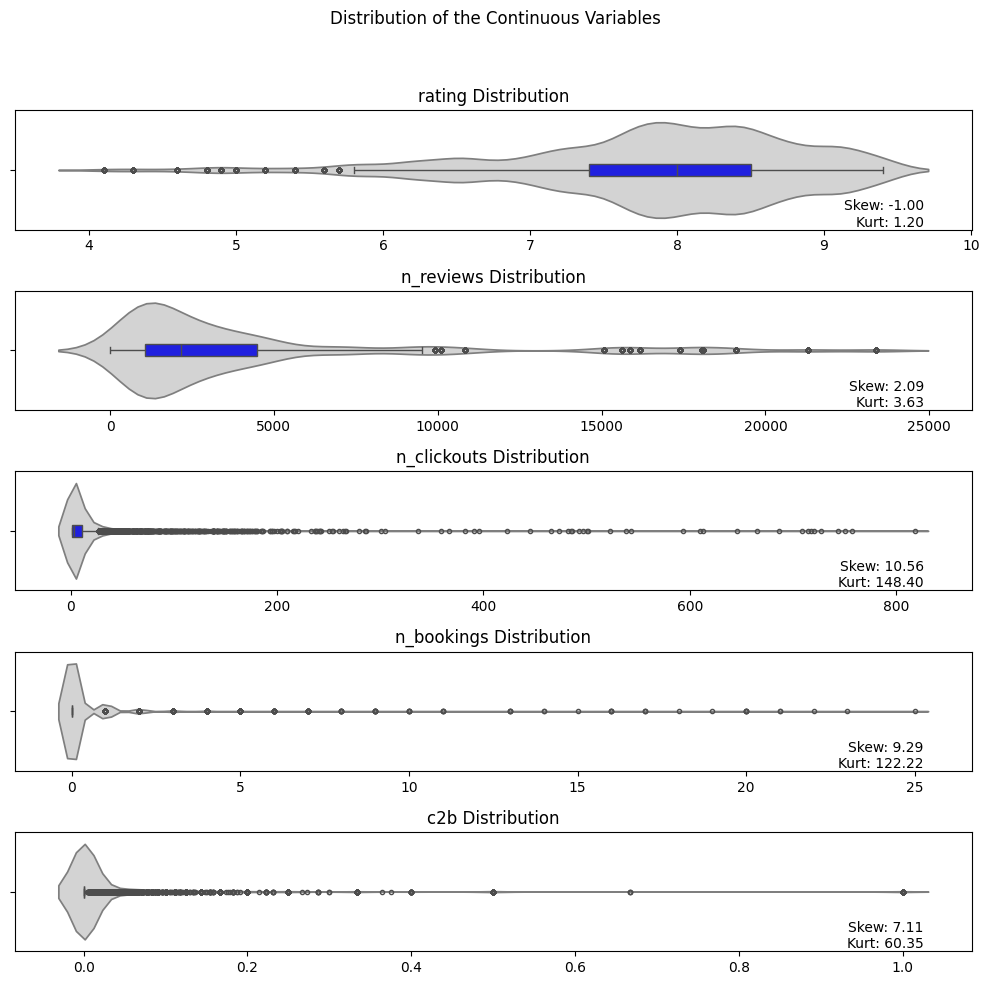

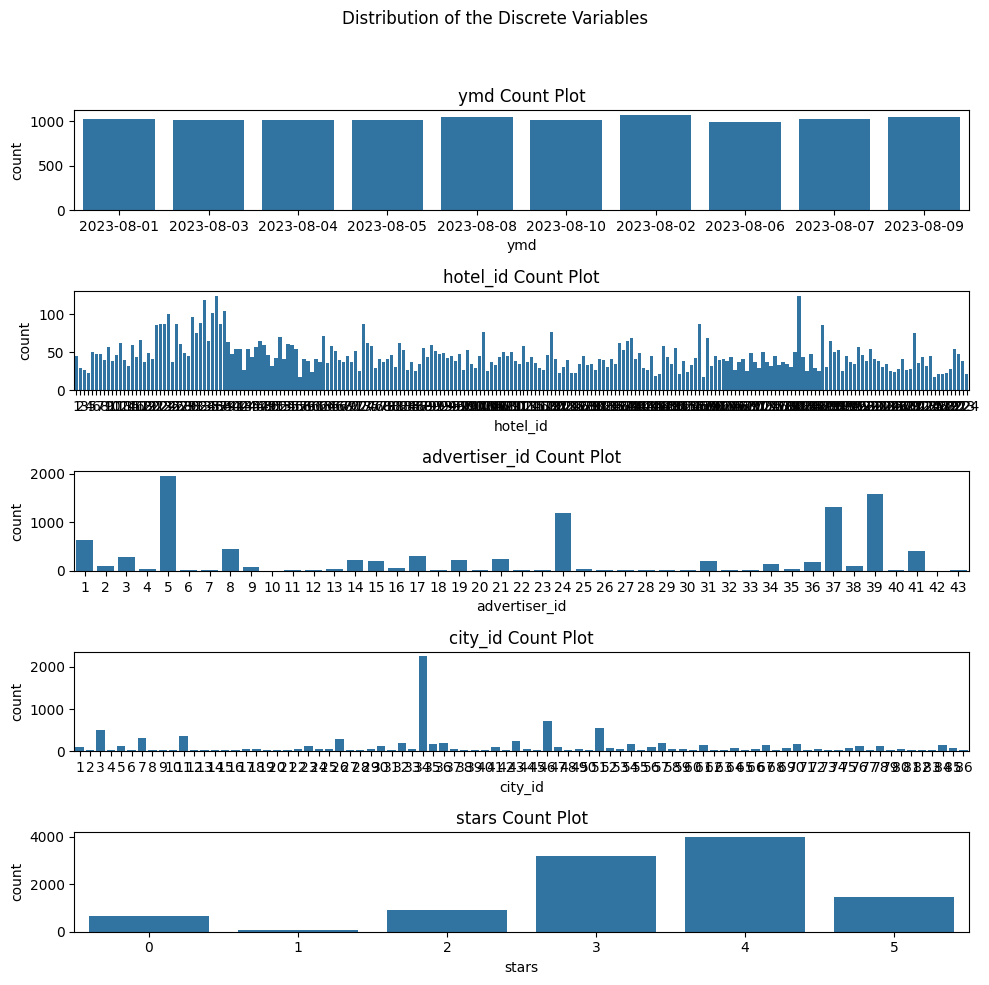

In [18]:
print(f"Descriptive statistics of the column data: \n{X.describe()}")

# Plotting data distribution
columns_of_interest = X.columns.tolist()
discrete_features_mask = [col in cols_categorical for col in X.columns]

continuous_vars = [col for col, is_discrete in zip(columns_of_interest, discrete_features_mask) if not is_discrete]
discrete_vars = [col for col, is_discrete in zip(columns_of_interest, discrete_features_mask) if is_discrete]

# Create figure for continuous variables
fig_continuous, axs_continuous = plt.subplots(nrows=len(continuous_vars), figsize=(10, 2*len(continuous_vars)))
plt.suptitle("Distribution of the Continuous Variables")

if len(continuous_vars) == 1:
    axs_continuous = [axs_continuous]

for i, var in enumerate(continuous_vars):
    axs_continuous[i].set_title(f'{var} Distribution')
    sns.violinplot(data=X, x=var, ax=axs_continuous[i], inner=None, orient="h", color='lightgray')
    sns.boxplot(data=X, x=var, ax=axs_continuous[i], width=0.1, fliersize=3, whis=1.5, orient="h", color='blue')
    skw = skew(X[var].dropna())
    kurt = kurtosis(X[var].dropna())
    axs_continuous[i].text(0.95, 0, f'Skew: {skw:.2f}\nKurt: {kurt:.2f}', ha='right', va='bottom', transform=axs_continuous[i].transAxes)
    axs_continuous[i].set_xlabel("")
plt.tight_layout(rect=(0, 0, 1, 0.95))

# Create figure for discrete variables
fig_discrete, axs_discrete = plt.subplots(nrows=len(discrete_vars), figsize=(10, 2*len(continuous_vars)))
plt.suptitle("Distribution of the Discrete Variables")

if len(discrete_vars) == 1:
    axs_discrete = [axs_discrete]

for i, var in enumerate(discrete_vars):
    sns.countplot(x=X[var], ax=axs_discrete[i] if len(discrete_vars) > 1 else axs_discrete)
    axs_discrete[i].set_title(f'{var} Count Plot')
plt.tight_layout(rect=(0, 0, 1, 0.95))

### Characterize Zero-Inflated Variables

I focus on characterizing the zero-inflation of `c2b` which will be used as target variable (its shifted version `c2b_tomorrow` will be the actual target variable). The zero-inflation in `c2b` stems from `n_bookings` and `n_clickouts`. The ratio of zero-inflated values is checked against the values of other variables to identify any biases. 

The target variable has considerable zero-inflation, about 80% on average. This necessitates careful data imputation, transformation, and model selection. While zero-inflated models like Zero-Inflated Poisson (ZIP) Regression or Zero-Inflated Negative Binomial (ZINB) Regression are suitable, this analysis uses standard nonlinear regression for simplicity. Metrics should reflect the model's ability to forecast non-zero values while adhering to the zero-inflated nature of the target; mean absolute error (MAE) is chosen for this analysis for its interpretability.

C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\1448107402.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_counts = data[data['c2b'] == 0].groupby(group_col).size().reset_index(name='zero_count')
C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\1448107402.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = data.groupby(group_col).size().reset_index(name='total_count')
C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\1448107402.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

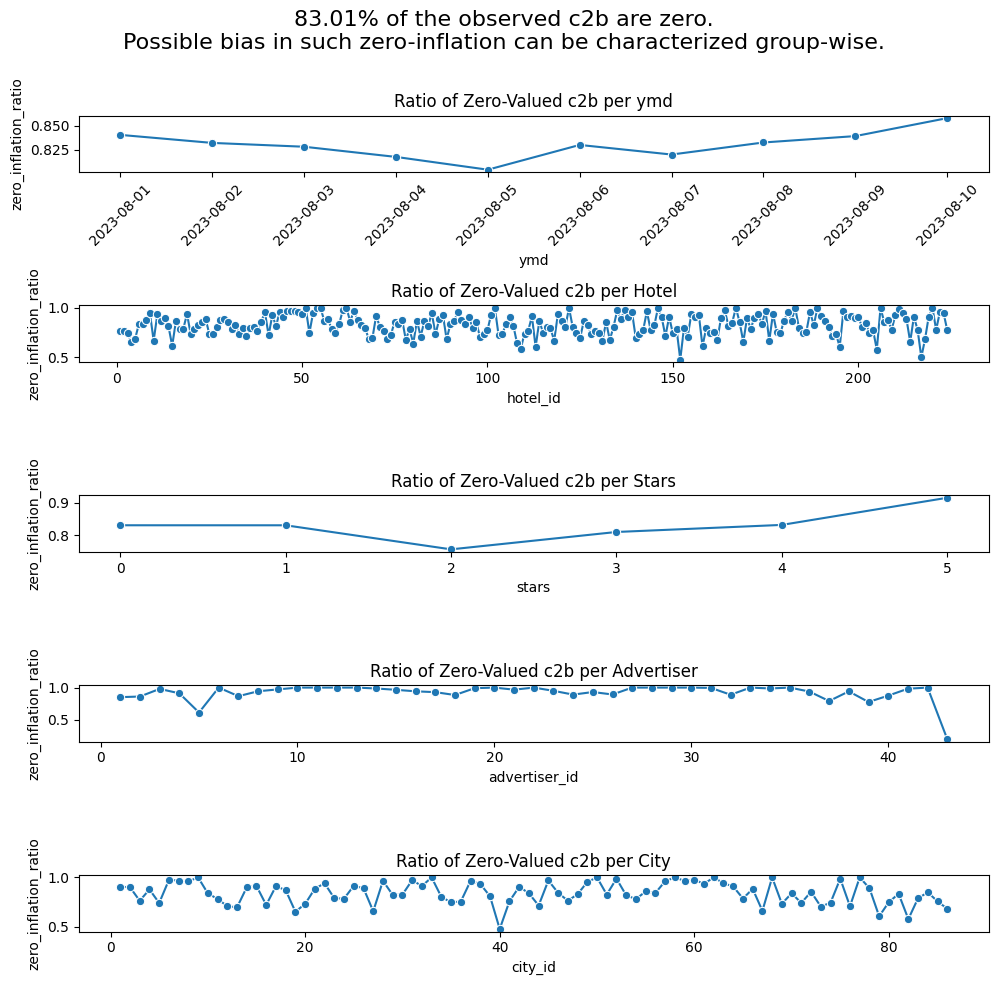

In [19]:
# Calculate the overall zero-inflation percentage
overall_zero_inflation = (X['c2b'] == 0).mean() * 100

def compute_zero_inflation_ratio(data: pd.DataFrame, group_col: str) -> pd.DataFrame:
    """
    Computes the zero-inflation ratio for the 'c2b' column within specified groups.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        group_col (str): The column name to group by.

    Returns:
        pd.DataFrame: A DataFrame containing the group, zero counts, total counts, and zero-inflation ratio.
    """
    zero_counts = data[data['c2b'] == 0].groupby(group_col).size().reset_index(name='zero_count')
    total_counts = data.groupby(group_col).size().reset_index(name='total_count')
    merged_counts = pd.merge(total_counts, zero_counts, on=group_col, how='left')
    merged_counts['zero_count'] = merged_counts['zero_count'].fillna(0)
    merged_counts['zero_inflation_ratio'] = merged_counts['zero_count'] / merged_counts['total_count']
    return merged_counts

# Compute zero inflation ratios for each group
zero_inflation_ymd = compute_zero_inflation_ratio(X, 'ymd')
zero_inflation_hotel = compute_zero_inflation_ratio(X, 'hotel_id')
zero_inflation_stars = compute_zero_inflation_ratio(X, 'stars')
zero_inflation_advertiser = compute_zero_inflation_ratio(X, 'advertiser_id')
zero_inflation_city = compute_zero_inflation_ratio(X, 'city_id')


# Plot the zero inflation ratios
fig, axs = plt.subplots(5, 1, figsize=(10, 2*5), sharex=False)
fig.suptitle(f'{overall_zero_inflation:.2f}% of the observed c2b are zero.\nPossible bias in such zero-inflation can be characterized group-wise.', fontsize=16)

sns.lineplot(data=zero_inflation_ymd, x='ymd', y='zero_inflation_ratio', marker='o', ax=axs[0])
axs[0].set_title('Ratio of Zero-Valued c2b per ymd')
axs[0].set_xticks(zero_inflation_ymd['ymd'])
axs[0].set_xticklabels(zero_inflation_ymd['ymd'].dt.strftime('%Y-%m-%d'), rotation=45)

sns.lineplot(data=zero_inflation_hotel, x='hotel_id', y='zero_inflation_ratio', marker='o', ax=axs[1])
axs[1].set_title('Ratio of Zero-Valued c2b per Hotel')

sns.lineplot(data=zero_inflation_stars, x='stars', y='zero_inflation_ratio', marker='o', ax=axs[2])
axs[2].set_title('Ratio of Zero-Valued c2b per Stars')

sns.lineplot(data=zero_inflation_advertiser, x='advertiser_id', y='zero_inflation_ratio', marker='o', ax=axs[3])
axs[3].set_title('Ratio of Zero-Valued c2b per Advertiser')

sns.lineplot(data=zero_inflation_city, x='city_id', y='zero_inflation_ratio', marker='o', ax=axs[4])
axs[4].set_title('Ratio of Zero-Valued c2b per City')

plt.tight_layout(rect=[0, 0, 1, 0.97])

### Outlier Detection

A random isolation forest is used for outlier detection. Outliers are validated through 2D projections and characterized by comparing their univariate distributions with non-outliers. 

Significant differences in median values are observed for `rating` and `n_reviews`, with the most notable difference in `n_bookings` and `c2b`. Most non-zero `n_bookings` are considered outliers, likely due to the zero-inflated nature of `n_bookings`. Arguably, the outlier determination is driven by the zero-inflated nature of the column `n_booking`, and therefore most samples are just to be considered valid points.

Random Isolation Forest identified 16 among 68 samples.

Outliers profiling: are these actual outliers or valid extreme data points?
Descriptive statistics of outliers:
          rating    n_reviews  n_clickouts  n_bookings        c2b
count  16.000000     16.00000    16.000000   16.000000  16.000000
mean    7.476562  10371.50000    59.625000    3.125000   0.080482
std     1.095703   7116.97283    98.851997    4.364631   0.122129
min     5.898438    843.00000     1.000000    0.000000   0.000000
25%     6.500000   4154.50000    10.250000    0.000000   0.000000
50%     7.548828   9085.50000    21.000000    2.000000   0.052778
75%     8.251953  16638.25000    76.000000    3.250000   0.094968
max     9.101562  23376.00000   396.000000   17.000000   0.500000
Descriptive statistics of non-outliers:
          rating     n_reviews  n_clickouts  n_bookings        c2b
count  52.000000     52.000000    52.000000   52.000000  52.000000
mean    8.101562   2602.423077    10.384615    0.250000   0.014

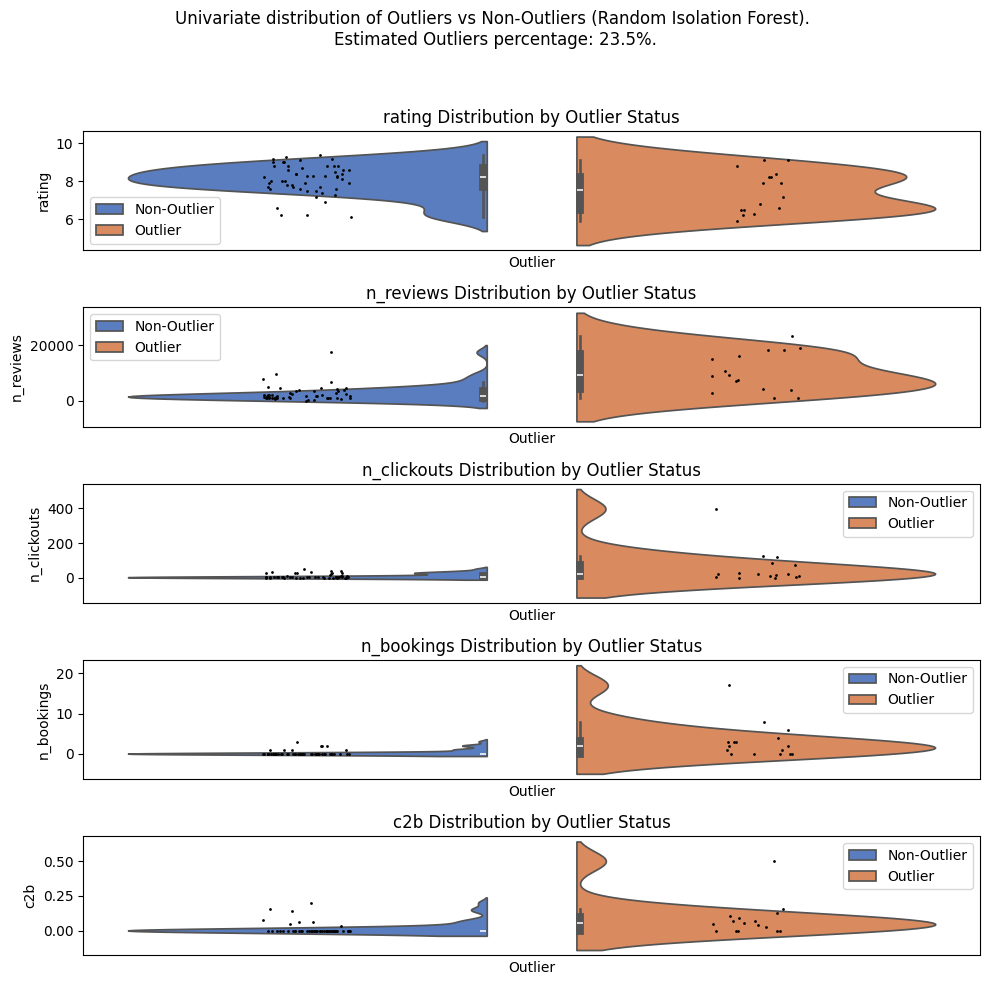

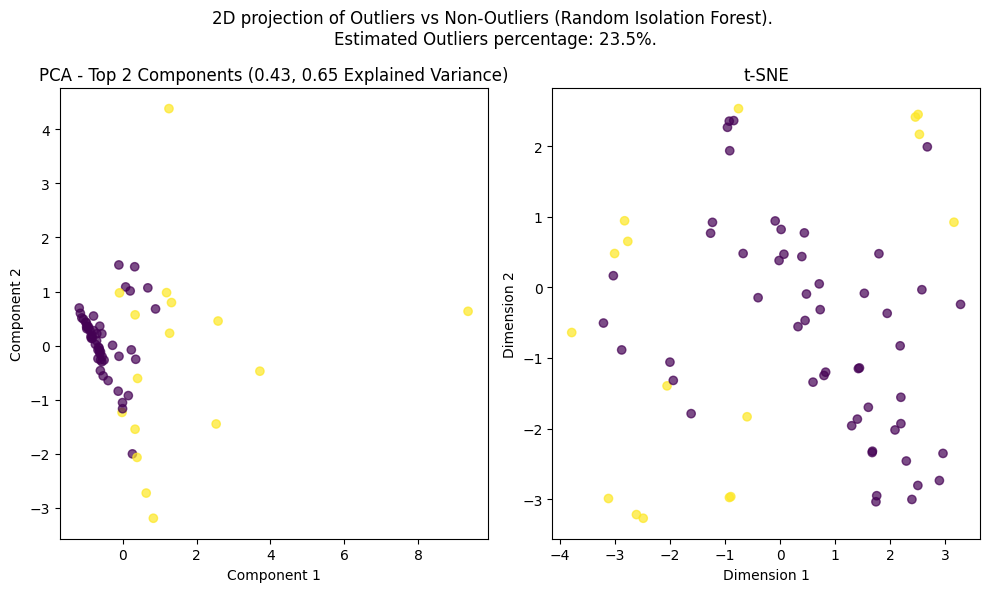

In [20]:
rif = IsolationForest(n_estimators=100, random_state=0).fit(X_sampled[cols_numerical])
outliers = rif.predict(X_sampled[cols_numerical]) == -1
outliers = pd.Series(outliers.astype(int), name='Outlier', index=X_sampled.index)
print(f"Random Isolation Forest identified {outliers.sum()} among {X_sampled.shape[0]} samples.\n")

print("Outliers profiling: are these actual outliers or valid extreme data points?")
print("Descriptive statistics of outliers:")
print(X_sampled.loc[outliers == 1, cols_numerical].describe())

print("Descriptive statistics of non-outliers:")
print(X_sampled.loc[outliers == 0, cols_numerical].describe())

# Visualize univariate distribution of outliers vs non-outliers
fig, axs = plt.subplots(nrows=len(cols_numerical), figsize=(10, 2*len(cols_numerical)))
plt.suptitle(f"Univariate distribution of Outliers vs Non-Outliers (Random Isolation Forest). \nEstimated Outliers percentage: {outliers.sum() / X_sampled.shape[0] * 100:.1f}%.")

if len(cols_numerical) == 1:
    axs = [axs]
for i, var in enumerate(cols_numerical):
    axs[i].set_title(f'{var} Distribution by Outlier Status')
    sns.violinplot(data=X_sampled, x=outliers, y=var, ax=axs[i], split=True, hue=outliers, palette='muted')
    sns.stripplot(data=X_sampled[cols_numerical], x=outliers, y=var, ax=axs[i], color='black', size=2, jitter=True)
    # Modify legend labels
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles[:2], ['Non-Outlier', 'Outlier'])
    # Hide x-ticks and x-tick labels
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
plt.tight_layout(rect=(0, 0, 1, 0.95))


# Compute 2D projections (PCA, t-SNE) of the continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sampled[cols_numerical])
# PCA Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)[:2]
# t-SNE Analysis
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

# Plot PCA and t-SNE data projections with highlighted outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2*3))
plt.suptitle(f"2D projection of Outliers vs Non-Outliers (Random Isolation Forest). \nEstimated Outliers percentage: {outliers.sum() / X_sampled.shape[0] * 100:.1f}%.")
# PCA Plot
ax1.set_title(f'PCA - Top 2 Components ({explained_variance[0]:.2f}, {explained_variance[1]:.2f} Explained Variance)')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, c=outliers.values)
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
# t-SNE Plot
ax2.set_title('t-SNE')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, c=outliers.values)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
plt.tight_layout()

### Feature-Target Relationships

These relationships are analyzed graphically with pair plots and numerically through Pearson or Spearman coefficients. 

The zero-inflated nature of the target is evident in pair plots, with most data points in the scatter plots being horizontally aligned at y = 0.

`n_bookings` has a moderate positive monotonic relationship with the target (Spearman=0.4), while `c2b` and `n_clickouts` have minor positive monotonic relationships (Spearman<=0.35). A nonlinear regression model is needed.

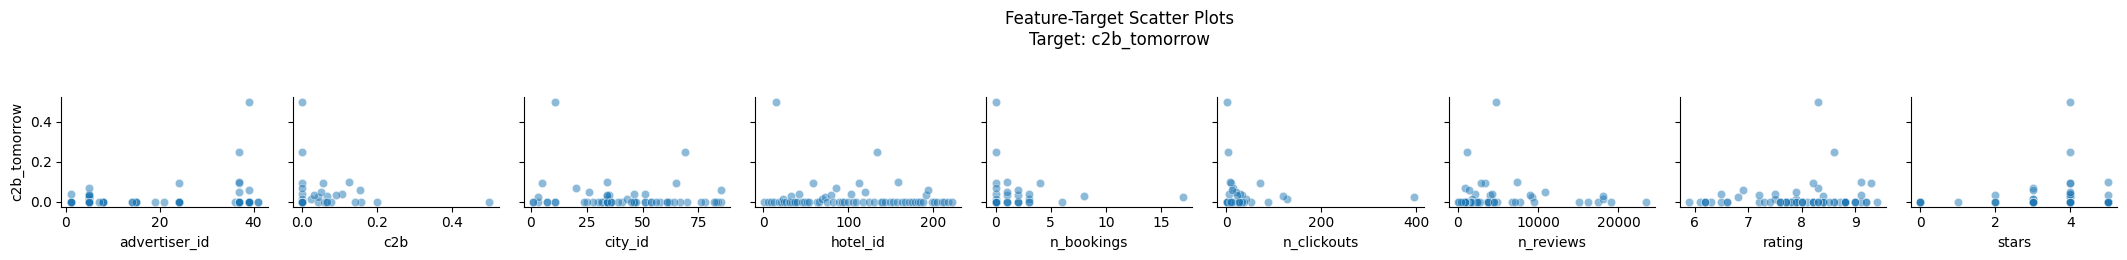

In [21]:
# Pairplot of features vs target ('c2b_tomorrow')
fig_pairplot = sns.pairplot(data=pd.concat([X_sampled, Y_sampled], axis=1),
                            x_vars=X_sampled.columns.difference(["ymd"]),
                            y_vars=["c2b_tomorrow"],
                            plot_kws={"alpha": 0.5})
plt.suptitle(f"Feature-Target Scatter Plots\nTarget: c2b_tomorrow", y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

Pearson correlations with the target (c2b_tomorrow):
Spearman correlations with the target (c2b_tomorrow):


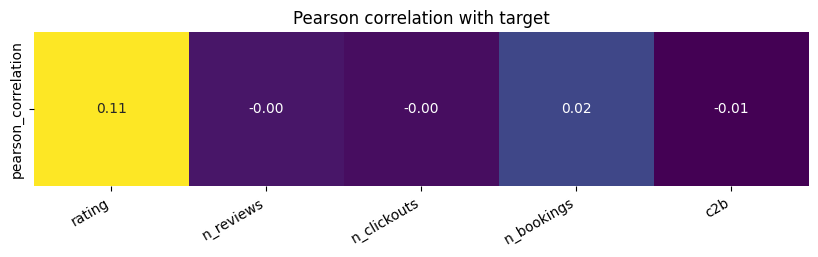

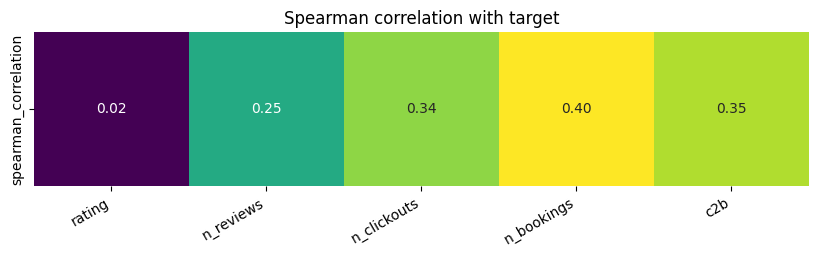

In [22]:
# Heatmap of the Pearson and Spearman correlation coefficients between numerical features and target
def compute_and_plot_correlation(data: pd.DataFrame, target: pd.Series, method: str = 'pearson'):
    """
    Computes and plots the correlation heatmap between numerical features and the target.

    Args:
        data (pd.DataFrame): The DataFrame containing the numerical features.
        target (pd.Series): The target variable.
        method (str): The correlation method to use ('pearson' or 'spearman').

    Returns:
        pd.DataFrame: DataFrame containing the correlation coefficients.
    """
    # Compute correlation of each column of data with the target
    corr_with_target = data.apply(lambda x: x.corr(target, method=method))
    # Convert to DataFrame for heatmap plotting
    corr_df = pd.DataFrame(corr_with_target, columns=[f'{method}_correlation'])

    # Plotting correlation heatmap
    plt.figure(figsize=(10, 2))
    sns.heatmap(corr_df.T, annot=True, cmap="viridis", cbar=False, fmt=".2f")
    plt.title(f"{method.capitalize()} correlation with target")
    plt.xticks(rotation=30, horizontalalignment="right")

    return corr_df

# Compute and plot Pearson correlation
print(f"Pearson correlations with the target ({'c2b_tomorrow'}):")
pearson_corr_df = compute_and_plot_correlation(X_sampled_no_ymd[cols_numerical], Y_sampled['c2b_tomorrow'], method='pearson')

# Compute and plot Spearman correlation
print(f"Spearman correlations with the target ({'c2b_tomorrow'}):")
spearman_corr_df = compute_and_plot_correlation(X_sampled_no_ymd[cols_numerical], Y_sampled['c2b_tomorrow'], method='spearman')

## Identify Seasonal Cycles

Seasonal cycles are identified through Fourier Transform analysis on the average `c2b` per day. 

Cyclical components with frequencies of 5 days (normalized power = 0.38) and 3 days (normalized power = 0.31) are found, suggesting the use of lag and windowed features with these durations.



Potential cycles in the target variable (dominant freq (in no. days), corresponding normalized power in PSD):
(5.0, 0.3639998504030445)
(10.0, 0.21314241569367856)
(2.0, 0.1865526261705558)
(3.333333333333333, 0.1333803235477014)
(2.5, 0.10292478418501969)


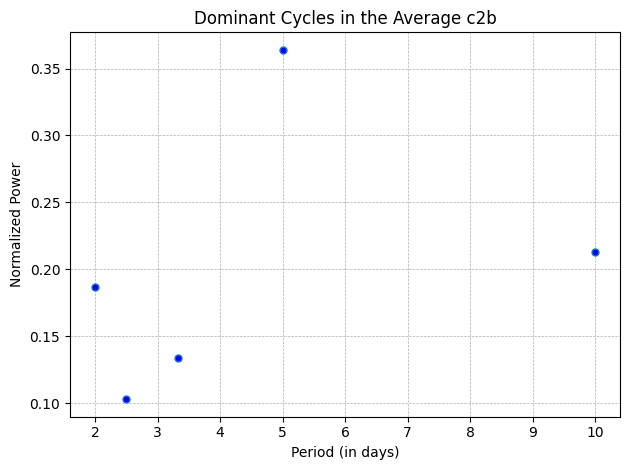

In [23]:
# Compute average c2b per day
average_c2b_per_day = X.groupby('ymd')['c2b'].mean().values

# Perform FFT and get frequencies and amplitudes
amplitudes = np.abs(np.fft.rfft(average_c2b_per_day))
frequencies = np.fft.rfftfreq(len(average_c2b_per_day), d=1)  # d = 1 indicates daily data

# Exclude the zero frequency (trend component)
frequencies = frequencies[1:]
amplitudes = amplitudes[1:]

# Calculate the periods from frequencies and pair them with amplitudes
periods_amplitudes = [(1 / freq, amp) for freq, amp in zip(frequencies, amplitudes) if freq != 0]

# Sort the periods and amplitudes by amplitude in descending order
periods_amplitudes.sort(key=lambda x: x[1], reverse=True)

# Normalize power by dividing each amplitude by the total power
total_power = sum([power for _, power in periods_amplitudes])
normalized_periods_amplitudes = [(freq, power / total_power) for freq, power in periods_amplitudes]

# Print the top 5 dominant cycles
print("\n\nPotential cycles in the target variable (dominant freq (in no. days), corresponding normalized power in PSD):")
print('\n'.join(map(str, normalized_periods_amplitudes[:5])))

# Visualize the dominant cycles
plt.figure()
plt.title('Dominant Cycles in the Average c2b')
freqs = [freq for freq, _ in normalized_periods_amplitudes]
normalized_powers = [power for _, power in normalized_periods_amplitudes]
plt.plot(freqs, normalized_powers, 'o', markersize=5, linewidth=1, markerfacecolor='blue')
plt.ylabel('Normalized Power')
plt.xlabel('Period (in days)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

### Characterize Unobserved Samples

About 50% of the samples are not observed, which may introduce noise if imputation is not carefully controlled. 

Options include controlling imputation to prevent exacerbating zero-inflation or minimizinig the amount of imputation performed. The former approach is used in the previously discussed approaches 1a and 1b for setting up the regression problem (impute all missing values, but tune the KNN imputer hyperparameters carefully), while the latter corresponds to what was discussed for the approach 2 (only impute missing values for August 10).

C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\387923489.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_counts = df.groupby(group_col).size().reset_index(name='observed')
C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\387923489.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_counts = df.groupby(group_col).size().reset_index(name='observed')
C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\387923489.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

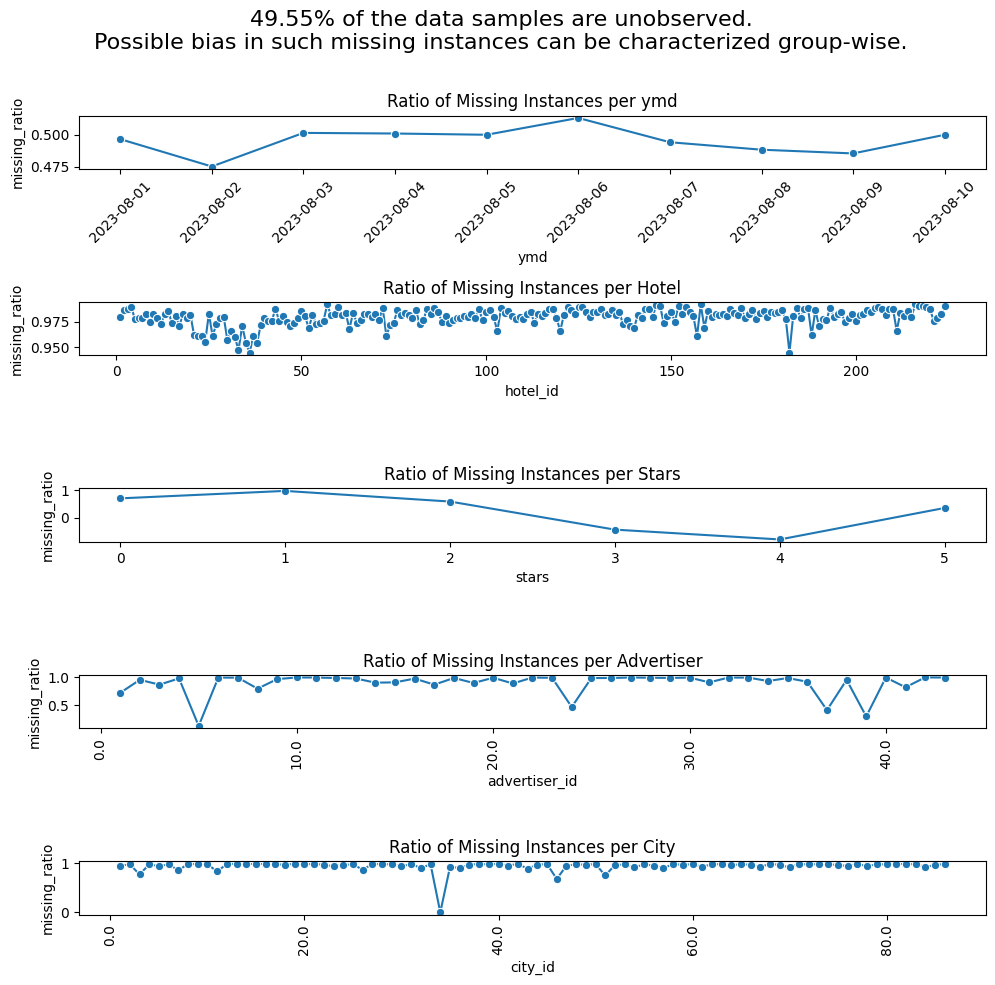

In [24]:
# List unique dates
unique_dates = pd.date_range(start=X['ymd'].min(), end=X['ymd'].max())

# Compute theoretical number of samples
n_combinations = X[['hotel_id', 'advertiser_id']].drop_duplicates().shape[0]

# Function to compute missing ratio
def compute_missing_ratio(df, group_col, total_possible):
    observed_counts = df.groupby(group_col).size().reset_index(name='observed')
    observed_counts['total'] = total_possible
    observed_counts['missing_ratio'] = 1 - (observed_counts['observed'] / observed_counts['total'])
    return observed_counts

# Compute missing ratios for ymd, hotel_id, stars, advertiser_id, and city_id
total_possible_ymd = n_combinations
total_possible_hotel = X['hotel_id'].nunique() * len(unique_dates)
total_possible_stars = X['hotel_id'].nunique() * len(unique_dates)
total_possible_advertiser = X['hotel_id'].nunique() * len(unique_dates)
total_possible_city = X['hotel_id'].nunique() * len(unique_dates)

# Compute missing ratios for each group
missing_ratios_ymd = compute_missing_ratio(X, 'ymd', total_possible_ymd)
missing_ratios_hotel = compute_missing_ratio(X, 'hotel_id', total_possible_hotel)
missing_ratios_stars = compute_missing_ratio(X, 'stars', total_possible_stars)
missing_ratios_advertiser = compute_missing_ratio(X, 'advertiser_id', total_possible_advertiser)
missing_ratios_city = compute_missing_ratio(X, 'city_id', total_possible_city)

# Calculate the overall unobserved percentage
total_possible_samples = n_combinations * len(unique_dates)
observed_samples = X.dropna(subset=['n_clickouts', 'n_bookings']).shape[0]  # Adjust columns as needed
overall_unobserved_percentage = (1 - (observed_samples / total_possible_samples)) * 100

# Plot the missing ratios
fig, axs = plt.subplots(5, 1, figsize=(10, 2*5), sharex=False)
fig.suptitle(f'{overall_unobserved_percentage:.2f}% of the data samples are unobserved.\nPossible bias in such missing instances can be characterized group-wise.', fontsize=16)

sns.lineplot(ax=axs[0], data=missing_ratios_ymd, x='ymd', y='missing_ratio', marker='o')
axs[0].set_title('Ratio of Missing Instances per ymd')
axs[0].set_xticks(missing_ratios_ymd['ymd'])
axs[0].set_xticklabels(missing_ratios_ymd['ymd'].dt.strftime('%Y-%m-%d'), rotation=45)

sns.lineplot(ax=axs[1], data=missing_ratios_hotel, x='hotel_id', y='missing_ratio', marker='o')
axs[1].set_title('Ratio of Missing Instances per Hotel')

sns.lineplot(ax=axs[2], data=missing_ratios_stars, x='stars', y='missing_ratio', marker='o')
axs[2].set_title('Ratio of Missing Instances per Stars')

sns.lineplot(ax=axs[3], data=missing_ratios_advertiser, x='advertiser_id', y='missing_ratio', marker='o')
axs[3].set_title('Ratio of Missing Instances per Advertiser')
axs[3].set_xticklabels(axs[3].get_xticks(), rotation=90)

sns.lineplot(ax=axs[4], data=missing_ratios_city, x='city_id', y='missing_ratio', marker='o')
axs[4].set_title('Ratio of Missing Instances per City')
axs[4].set_xticklabels(axs[4].get_xticks(), rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.97])

## Data Imputation

Impute all missing samples, then evaluate the quality of the imputation by comparing the distribution of the original and imputed samples. 

Create samples for any missing combinations of `hotel_id`, `advertiser_id`, and `ymd` (date). For each newly created sample, copy the static characteristics of the hotel, such as `stars`, `city_id`, `rating`, and `n_reviews`, which do not change over the examined period. For the dynamically changing values, such as `n_bookings` and `n_clickouts`, use the KNN imputation method. Special care is taken in choosing the KNN parameters to limit further zero-inflation of the imputed values. K=2 and distance-weighted averaging are used to favor the detection of local patterns over smoothed values that would most likely be zero or close to zero.

The analysis of the imputed values reveals that, despite tuning the hyperparameters of the KNN imputer, this imputation further contributes to the zero-inflation of the metrics `n_bookings` and `n_clickouts`, therefore of `c2b`. This suggests that the regression approach should be tried out (only imputing values for August 10).

In [25]:
# Exclude the original 'ymd' column from the columns to be imputed
impute_cols = ['n_clickouts', 'n_bookings']
all_features = ['ymd', 'advertiser_id', 'city_id', 'stars', 'rating', 'n_reviews', 'n_clickouts', 'n_bookings']

# Prepare the DataFrame for imputation
complete_data = pd.DataFrame()
all_dates = pd.DataFrame(X["ymd"].unique(), columns=["ymd"])

for (hotel_id, advertiser_id), group in X.groupby(['hotel_id', 'advertiser_id'], observed=True):
    group_complete = group.merge(all_dates, on='ymd', how='outer')
    group_complete['hotel_id'] = hotel_id
    group_complete['advertiser_id'] = advertiser_id
    group_complete['city_id'] = group['city_id'].iloc[0]
    group_complete['stars'] = group['stars'].iloc[0]
    group_complete['rating'] = group['rating'].iloc[0]
    group_complete['n_reviews'] = group['n_reviews'].iloc[0]
    complete_data = pd.concat([complete_data, group_complete], ignore_index=True)

complete_data['imputed_day'] = complete_data[impute_cols].isna().any(axis=1).astype("uint8")

# Convert 'ymd' to numeric format YYYYMMDD
complete_data['ymd'] = complete_data['ymd'].dt.strftime('%Y%m%d').astype(int)

def impute_group(group):
    imputer = KNNImputer(n_neighbors=2, weights="distance")
    imputed_data = imputer.fit_transform(group[all_features])
    imputed_df = pd.DataFrame(imputed_data, columns=all_features, index=group.index)
    group[impute_cols] = imputed_df[impute_cols]
    return group

complete_data = complete_data.groupby(['hotel_id']).apply(impute_group).reset_index(drop=True)

# Convert 'ymd' back to datetime format
complete_data['ymd'] = pd.to_datetime(complete_data['ymd'].astype(str), format='%Y%m%d')

# Recompute the c2b for the imputed samples
complete_data["c2b"] = complete_data["n_bookings"] / complete_data["n_clickouts"]

# Create the target variable c2b_tomorrow by shifting c2b (predict c2b_tomorrow using information from day t)
complete_target = complete_data[['ymd', 'hotel_id', 'advertiser_id', 'c2b']].copy()
complete_target["c2b_tomorrow"] = complete_target.groupby(["hotel_id", "advertiser_id"], observed=True)["c2b"].shift(-1).fillna(-1)

# Create an indicator 'imputed_day_tomorrow' that the 'c2b_tomorrow' was imputed, by shifting 'imputed_day'
complete_data['imputed_day_tomorrow'] = complete_data.groupby(["hotel_id", "advertiser_id"], observed=True)["imputed_day"].shift(-1).fillna(1).astype("uint8")

# Optimize data types of new columns for memory efficiency
complete_data[['imputed_day', 'imputed_day_tomorrow']] = complete_data[['imputed_day', 'imputed_day_tomorrow']].astype('category')

# Sort columns in complete_data
complete_data = complete_data.sort_values(by=["hotel_id", "advertiser_id", "ymd"]).reset_index(drop=True)
complete_data = complete_data[['ymd', 'hotel_id', 'advertiser_id', 'city_id', 'stars', 'rating', 'n_reviews', 'n_clickouts', 'n_bookings', 'imputed_day', 'c2b']]

# Sort columns in complete_target
complete_target = complete_target.sort_values(by=["hotel_id", "advertiser_id", "ymd"]).reset_index(drop=True)
complete_target = complete_target[['c2b_tomorrow']]

# Set X to the complete data
X = complete_data

# Override Y with the target DataFrame
Y = complete_target

del complete_data, complete_target

C:\Users\gigli\AppData\Local\Temp\ipykernel_16704\3407968162.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complete_data = complete_data.groupby(['hotel_id']).apply(impute_group).reset_index(drop=True)


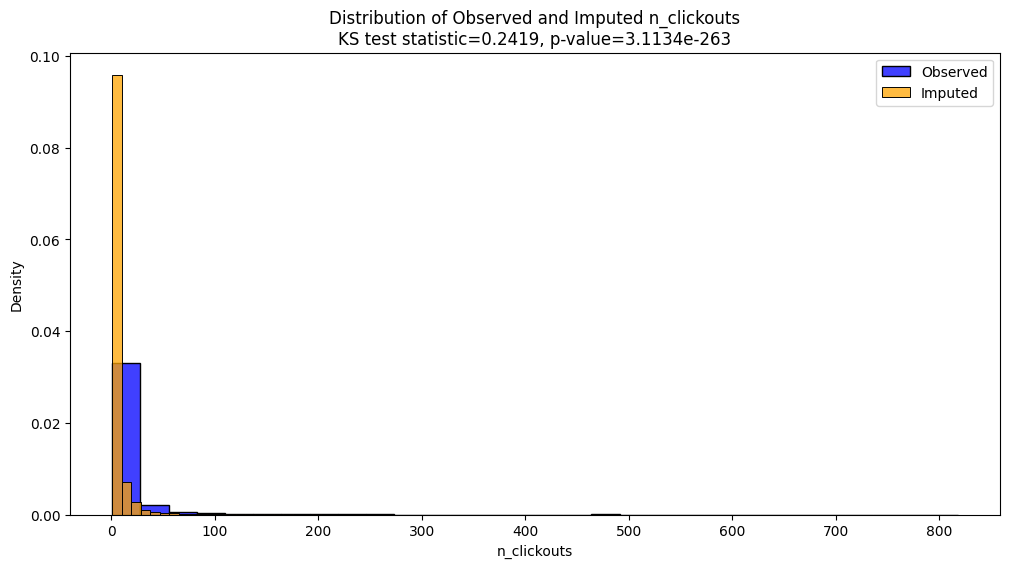

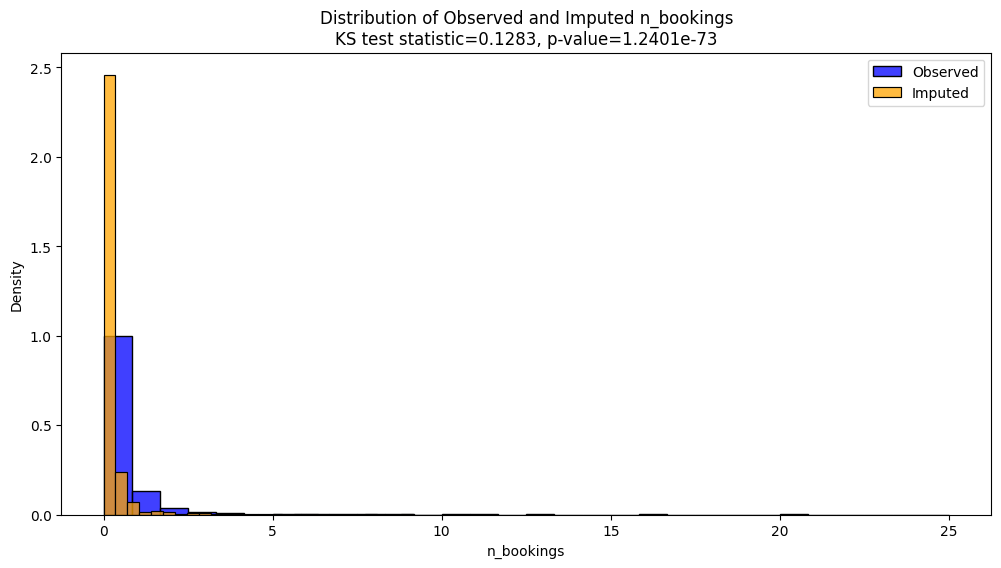

In [26]:
def evaluate_imputation(data: pd.DataFrame, variable: str, imputed_mask: str) -> None:
    """
    Evaluates the imputation of a specified variable by comparing the distributions
    of observed and imputed values. Creates overlapping histograms using Seaborn
    and writes the results of the Kolmogorov-Smirnov test in the title of the image.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        variable (str): The name of the variable to evaluate.
        imputed_mask (str): Column name in the DataFrame indicating which values are imputed.
    """
    imputed_mask = data[imputed_mask]

    observed_values = data.loc[imputed_mask == 0, variable]
    imputed_values = data.loc[imputed_mask == 1, variable]

    # Perform Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(observed_values, imputed_values)

    # Create overlapping histograms
    plt.figure(figsize=(12, 6))
    sns.histplot(observed_values, bins=30, color='blue', label='Observed', stat="density")
    sns.histplot(imputed_values, bins=30, color='orange', label='Imputed', stat="density")
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'Distribution of Observed and Imputed {variable}\nKS test statistic={ks_stat:.4f}, p-value={p_value:.4e}')

# Evaluate imputation for 'n_clickouts' and 'n_bookings'
evaluate_imputation(X, 'n_clickouts', 'imputed_day')
evaluate_imputation(X, 'n_bookings', 'imputed_day')

## Feature Extraction

Historical features were generated by calculating lagged values and rolling window statistics for conversion rates for each hotel-advertiser combination ([2, 3, 5, 7]-days-lookback). Mean encodings were applied to capture the average conversion rates across different groups such as hotel, advertiser, city, and star ratings. A seasonal indicator based on days of the week has been included to capture periodic trends.

In [27]:
# Correct mild negative skewness of "rating" with stretching transformation
X["rating"] = np.power(X["rating"], 2)

# Correct positive skewness of "n_reviews" with squashing transformation
X["n_reviews"] = np.log1p(X["n_reviews"])

In [28]:
# Add weekday column as a seasonality indicator
X['weekday'] = X['ymd'].dt.dayofweek  # Monday = 0, Sunday = 6

In [29]:
# Group the data by `hotel_id` and `advertiser_id`
grouped = X.groupby(['hotel_id', 'advertiser_id'])

# Create lag features for conversion rate (c2b) for specified lag periods (e.g., 1, 3, 7 days)
lags = [2, 3, 5, 7]
for lag in lags:
    X[f'c2b_lag_{lag}'] = grouped['c2b'].shift(lag)

# Compute rolling window statistics (mean) for specified window sizes (e.g., 3, 7 days)
windows = [2, 3, 5, 7]
for window in windows:
    X[f'c2b_roll_mean_{window}'] = grouped['c2b'].rolling(window=window).mean().reset_index(level=['hotel_id', 'advertiser_id'], drop=True)

In [30]:
# Mean encodings for the c2b by hotel, by advertiser, by city, and by stars
X['c2b_mean_hotel'] = X.groupby('hotel_id')['c2b'].transform('mean')
X['c2b_mean_advertiser'] = X.groupby('advertiser_id')['c2b'].transform('mean')
X['c2b_mean_city'] = X.groupby('city_id')['c2b'].transform('mean')
X['c2b_mean_stars'] = X.groupby('stars')['c2b'].transform('mean')

In [31]:
print("Design Matrix (X):")
display(X.head())

print("\nTarget Matrix (Y):")
display(Y.head())

Design Matrix (X):


,ymd,hotel_id,advertiser_id,city_id,stars,rating,n_reviews,n_clickouts,n_bookings,imputed_day,c2b,weekday,c2b_lag_2,c2b_lag_3,c2b_lag_5,c2b_lag_7,c2b_roll_mean_2,c2b_roll_mean_3,c2b_roll_mean_5,c2b_roll_mean_7,c2b_mean_hotel,c2b_mean_advertiser,c2b_mean_city,c2b_mean_stars
0,2023-08-01,1,1,36,3,37.21875,8.189245,5.0,0.0,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045685,0.031703,0.029434,0.027208
1,2023-08-02,1,1,36,3,37.21875,8.189245,5.0,0.0,1,0.0,2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.045685,0.031703,0.029434,0.027208
2,2023-08-03,1,1,36,3,37.21875,8.189245,5.0,0.0,0,0.0,3,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.045685,0.031703,0.029434,0.027208
3,2023-08-04,1,1,36,3,37.21875,8.189245,2.0,0.0,0,0.0,4,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.045685,0.031703,0.029434,0.027208
4,2023-08-05,1,1,36,3,37.21875,8.189245,1.0,0.0,0,0.0,5,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.045685,0.031703,0.029434,0.027208



Target Matrix (Y):


,c2b_tomorrow
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Split Data into Training, Development, and Test Sets.

Data is split according to the previously discussed regression strategy 1a:

1. **Training Set**: Design matrix contains samples from August 8. Note that data from August 8-th includes lag and windowed features of up to 7 days prior. The target matrix consists of the `c2b` on August 9.
2. **Development Set**: Used to evaluate the trained model. Design matrix contains samples from August 9. The target matrix consists of the `c2b` on August 10.
3. **Test Set**: Design matrix contains samples from August 10. The target matrix is not available.

The validation set is not explicitly extracted: K-Fold cross-validation will be used on the training set for hyperparameter optimization.

In [32]:
# Define the dates for the splits
train_dates = [pd.Timestamp("2023-08-08")]  # The first useful training day depends on the largest lag/window_size used in the feature extraction.
dev_dates = [pd.Timestamp("2023-08-09")]
test_dates = [pd.Timestamp("2023-08-10")]

# Split the data based on the defined dates
X_train = X[X["ymd"].isin(train_dates)]
Y_train = Y[X["ymd"].isin(train_dates)]
ymd_X_train = X_train["ymd"]
X_train = X_train.drop(columns=["ymd"])

X_dev = X[X["ymd"].isin(dev_dates)]
Y_dev = Y[X["ymd"].isin(dev_dates)]
ymd_X_dev = X_dev["ymd"]
X_dev = X_dev.drop(columns=["ymd"])

X_test = X[X["ymd"].isin(test_dates)]
Y_test = Y[X["ymd"].isin(test_dates)]
ymd_X_test = X_test["ymd"]
X_test = X_test.drop(columns=["ymd"])

# Check each matrix shape and absence of nan
print("Training set:")
print(f"X_train shape: {X_train.shape}")
print(f"X_train contains nans: {X_train.isna().any().any()}")  # nan may appear if the chosen lag/window_size exceeds the first training day - 1
print(f"Y_train shape: {Y_train.shape}")

print("\nDevelopment set:")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_dev contains nans: {X_dev.isna().any().any()}")
print(f"Y_dev shape: {Y_dev.shape}")

print("\nTest set:")
print(f"X_test shape: {X_test.shape}")
print(f"X_test contains nans: {X_test.isna().any().any()}")
print(f"Y_test shape: {Y_test.shape}")

Training set:
X_train shape: (2040, 23)
X_train contains nans: False
Y_train shape: (2040, 1)

Development set:
X_dev shape: (2040, 23)
X_dev contains nans: False
Y_dev shape: (2040, 1)

Test set:
X_test shape: (2040, 23)
X_test contains nans: False
Y_test shape: (2040, 1)


## Model Tuning and Training

This section defines the main metric and scorer, defines the learning model, optimizes hyperparameters via randomized cross-validation with k-fold, and checks the hyperparameters. Specifically:

1. **Metric and Scorer Definition**: MAE was chosen as the primary metric, and `neg_mean_absolute_error` as the scoring function for hyperparameter optimization. MAE is equally influenced by small and large errors, making it easily interpretable in heteroscedastic prediction problems. Moreover, MAE provided slightly better graphical performance on both training and development sets compared to alternative metrics such as RMSE and a weighted mixture of range-normalized MAE and range-normalized RMSE.
2. **Baseline Performance**: A DummyRegressor with a mean strategy was used to establish baseline performance.
3. **Model Definition**: A ClippedRegressor with a base LightGBM regressor was defined to ensure predictions are non-negative. The LightGBM regressor was selected for its ability to handle nonlinearity, robustness to heteroscedastic data, and compatibility with both numerical and categorical features. It also provides valuable measures of feature importance.
4. **Hyperparameter Optimization**: RandomizedSearchCV with GroupKFold cross-validation was used to find the best hyperparameters.
5. **Evaluation of Hyperparameters**: The best hyperparameters were evaluated numerically and graphically.

### Define evaluation metric and scorer

In [33]:
# def zero_inflated_nrmse_nmae(y_true: np.array, y_pred: np.array) -> float:
#     """
#     Evaluates the prediction error for zero-inflated data by combining normalized MAE for zero-valued y_true and
#     normalized RMSE for non-zero-valued y_true. The normalizing factor is the range of y_true. The weights are computed
#     based on the ratio of zero-valued y_true in the data.
#     The combined error is computed as:
#     combined_error = weight_nmae * NMAE_zero + (1 - weight_nmae) * NRMSE_nonzero
#     where weight_nmae = len(y_true_zero) / len(y_true).
#     Args:
#         y_true (np.array): True values.
#         y_pred (np.array): Predicted values.
#     Returns:
#         float: Combined normalized error.
#     """
#     y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()

#     # Split the data into two subsets: ground truth equals zero and ground truth greater than zero
#     y_true_zero, y_pred_zero = y_true[y_true == 0], y_pred[y_true == 0]
#     y_true_nonzero, y_pred_nonzero = y_true[y_true > 0], y_pred[y_true > 0]

#     # Calculate the MAE for the zero subset
#     mae_zero = mean_absolute_error(y_true_zero, y_pred_zero) if len(y_true_zero) > 0 else 0

#     # Calculate the RMSE for the non-zero subset
#     rmse_nonzero = root_mean_squared_error(y_true_nonzero, y_pred_nonzero) if len(y_true_nonzero) > 0 else 0

#     # Normalize both metrics if the range of y_true is greater than zero
#     range_y_true = np.ptp(y_true)
#     if range_y_true > 0:
#         nmae_zero = mae_zero / range_y_true
#         nrmse_nonzero = rmse_nonzero / range_y_true
#     else:
#         nmae_zero = mae_zero
#         nrmse_nonzero = 0

#     # Compute weights
#     weight_nmae = len(y_true_zero) / len(y_true)
#     weight_nrmse = 1 - weight_nmae

#     # Combine the two errors using computed weights
#     combined_error = weight_nmae * nmae_zero + weight_nrmse * nrmse_nonzero
#     return combined_error


# # Create the scorer for use in scikit-learn
# neg_zero_inflated_nrmse_nmae_scorer = make_scorer(zero_inflated_nrmse_nmae, greater_is_better=False)

# # Set the metric function and name for convenience
# metric_fn = zero_inflated_nrmse_nmae
# metric_name = "ZI_NRMSE_NMAE"
# metric_score = neg_zero_inflated_nrmse_nmae_scorer

In [34]:
# # Define main metric and scorer for hyperparameter optimization 
# metric_fn = root_mean_squared_error
# metric_name = "RMSE"
# metric_score = "neg_root_mean_squared_error"

In [35]:
# Define main metric and scorer for hyperparameter optimization 
metric_fn = mean_absolute_error
metric_name = "MAE"
metric_score = "neg_mean_absolute_error"

In [36]:
# Compute baseline performance with a DummyRegressor
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, Y_train)
Y_train_baseline_pred = baseline_model.predict(X_train)
Y_dev_baseline_pred = baseline_model.predict(X_dev)
Y_test_baseline_pred = baseline_model.predict(X_test)
# Compute baseline performance for training, development, and test sets
baseline_train_perf = metric_fn(Y_train.values.squeeze(), Y_train_baseline_pred)
baseline_train_rmse = root_mean_squared_error(Y_train.values.squeeze(), Y_train_baseline_pred)
baseline_train_r2 = r2_score(Y_train.values.squeeze(), Y_train_baseline_pred)
baseline_dev_perf = metric_fn(Y_dev.values.squeeze(), Y_dev_baseline_pred)
baseline_dev_rmse = root_mean_squared_error(Y_dev.values.squeeze(), Y_dev_baseline_pred)
baseline_dev_r2 = r2_score(Y_dev.values.squeeze(), Y_dev_baseline_pred)

### Define a custom regression model

Based on lgb.LGBMRegressor() that clips the predictions to zero.

In [37]:
class ClippedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_regressor=None):
        self.base_regressor = base_regressor if base_regressor is not None else Ridge()

    def fit(self, X, y):
        self.base_regressor.fit(X, y)
        return self

    def predict(self, X):
        predictions = self.base_regressor.predict(X)
        return np.clip(predictions, a_min=0, a_max=None)

    def get_params(self, deep=True):
        return {'base_regressor': self.base_regressor}

    def set_params(self, **params):
        base_regressor_params = {k.split('__', 1)[1]: v for k, v in params.items() if k.startswith('base_regressor__')}
        self.base_regressor.set_params(**base_regressor_params)
        return self

model = ClippedRegressor(base_regressor=lgb.LGBMRegressor(random_state=0))

### Execute hyperparmeter optimization 

By RandomizedSearchCV with k-fold strategy.

In [38]:
# Create kfold split for model validation based on hotel_id
group_kfold = GroupKFold(n_splits=5)
splits = list(group_kfold.split(X_train, Y_train, groups=X_train['hotel_id']))

In [39]:
# param_distributions for LGBMRegressor
param_distributions = {
    'base_regressor__num_leaves': randint(20, 32),  #
    'base_regressor__min_child_samples': randint(20, 30),  # No. samples in the leaves. Higher values contrast overfitting.
    'base_regressor__learning_rate': loguniform(0.01, 0.1),
    'base_regressor__n_estimators': randint(100, 300),
}

In [40]:
# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=40,  # Number of parameter settings that are sampled
    refit=True,
    cv=splits,
    scoring=metric_score,
    verbose=1,  # Verbosity level
    random_state=0,
)

# Perform the random search on the training data
print("Starting Randomized Search for Hyperparameter Optimization...")
random_search.fit(X_train, Y_train)

Starting Randomized Search for Hyperparameter Optimization...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 22
[LightGBM] [Info] Start training from score 0.023499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 22
[LightGBM] [Info] Start training from score 0.024129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 2037, 2038, 2039]),
                        array([  10,   11,   12,   13,   14,   15,   16,   17,   18,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   81,   82,   83,
         84,   85,   86,   87,   88,   89,   90,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  171,  172,
        173,  174,  175,  176,  177,  237,  238,  239,  240,  241,  242,
        243,  244,  245,  246,  247,  248,  249,  250,  251,  378,  379,
        380,  381,  382,  383,  3...
                                        'base_regressor__min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B2615634D0>,
                                        'base_regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B25F81CF90>,
                                        'base_regressor__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B261F9C810>},
                   random_state=0, scoring='neg_mean_absolute_error',
                   verbose=1)

### Check the cross-validation results

In [41]:
# Summary of the best estimator
best_model = random_search.best_estimator_
print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"Best training set negative {metric_name}: {random_search.best_score_}")


Best hyperparameters found:
{'base_regressor__learning_rate': 0.0186212132294769, 'base_regressor__min_child_samples': 22, 'base_regressor__n_estimators': 207, 'base_regressor__num_leaves': 20}
Best training set negative MAE: -0.02984973935839544



Best hyperparameters found:
{'base_regressor__learning_rate': 0.0186212132294769, 'base_regressor__min_child_samples': 22, 'base_regressor__n_estimators': 207, 'base_regressor__num_leaves': 20}
Best cross-validation score: -0.02984973935839544

Top 10 hyperparameter combinations:


,params,mean_test_score,std_test_score,rank_test_score
35,{'base_regressor__learning_rate': 0.0186212132...,-0.029850,0.001697,1
11,{'base_regressor__learning_rate': 0.0153579179...,-0.029854,0.001717,2
22,{'base_regressor__learning_rate': 0.0137462092...,-0.029969,0.002064,3
27,{'base_regressor__learning_rate': 0.0228793911...,-0.029972,0.001656,4
36,{'base_regressor__learning_rate': 0.0177318130...,-0.029988,0.002086,5
31,{'base_regressor__learning_rate': 0.0208242300...,-0.030033,0.001879,6
5,{'base_regressor__learning_rate': 0.0117770375...,-0.030061,0.002181,7
13,{'base_regressor__learning_rate': 0.0409350874...,-0.030077,0.001865,8
21,{'base_regressor__learning_rate': 0.0217774795...,-0.030090,0.001853,9
6,{'base_regressor__learning_rate': 0.0233475621...,-0.030170,0.001948,10


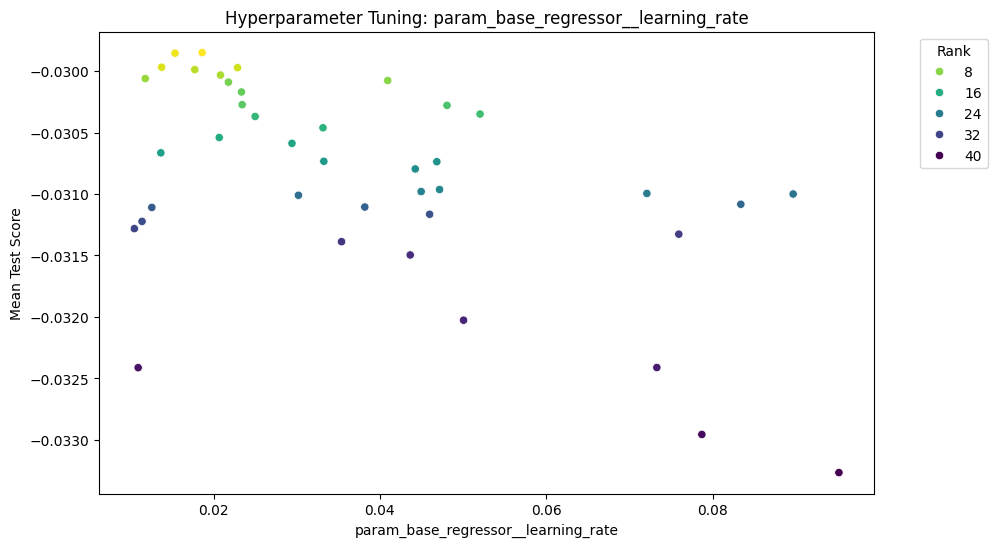

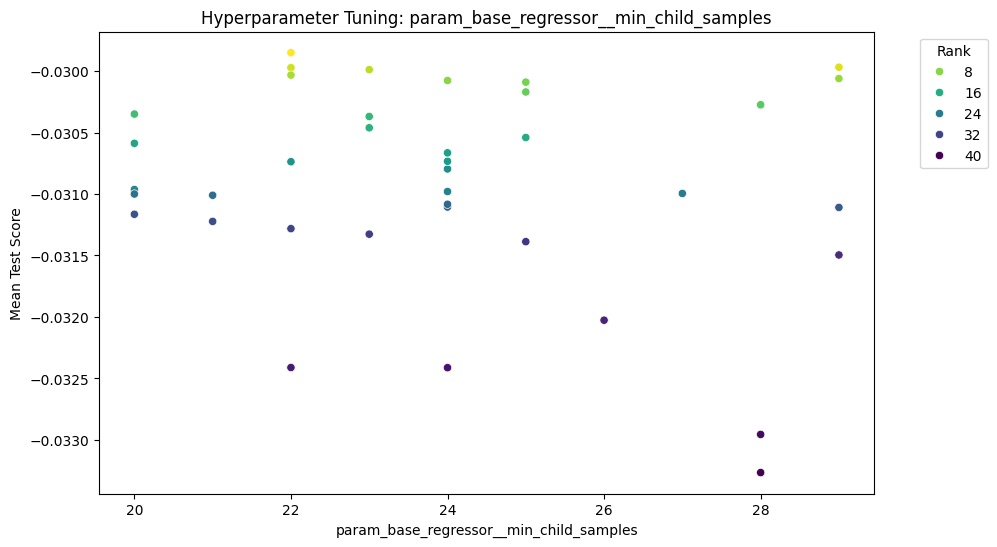

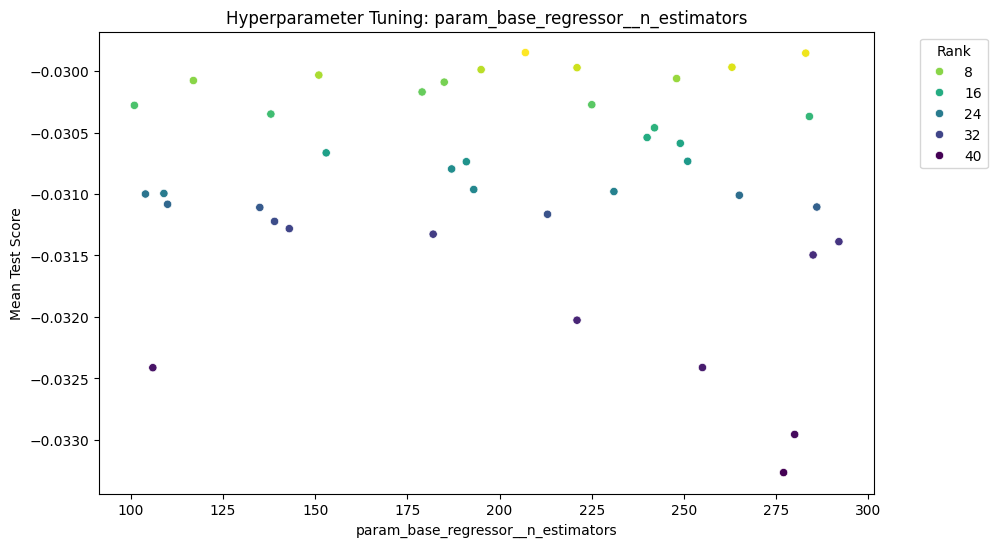

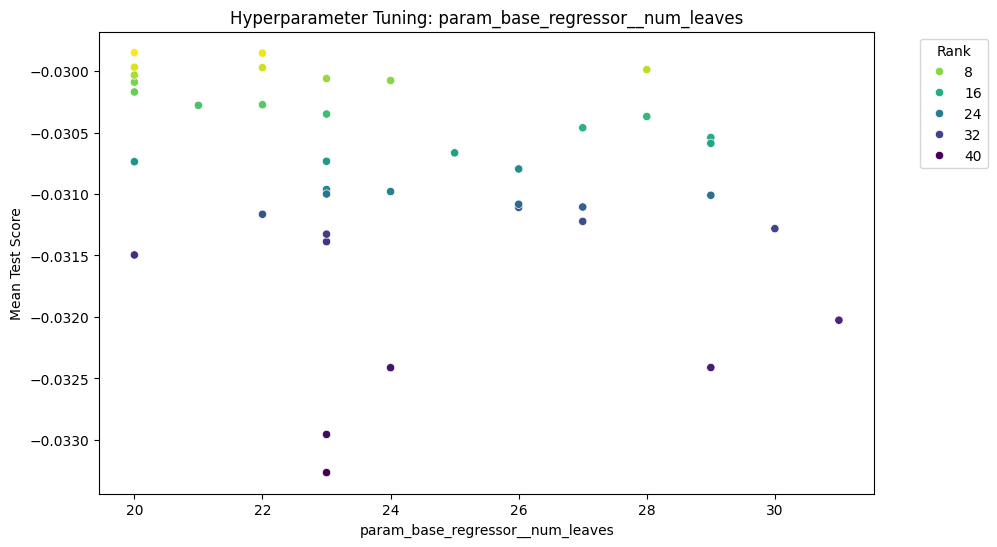

In [42]:
def evaluate_random_search(random_search):
    # Print best hyperparameters and score
    print("\nBest hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best cross-validation score: {random_search.best_score_}")

    # Convert cv_results_ to DataFrame
    results_df = pd.DataFrame(random_search.cv_results_)

    # Display top 10 configurations
    top_results = results_df.sort_values(by='rank_test_score').head(10)
    print("\nTop 10 hyperparameter combinations:")
    display(top_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

    # Plot the results
    param_cols = [col for col in results_df.columns if col.startswith('param_')]
    for param in param_cols:
        plt.figure(figsize=(10, 6))
        scatter = sns.scatterplot(data=results_df, x=param, y='mean_test_score', hue='rank_test_score', palette='viridis_r')
        scatter.set_title(f'Hyperparameter Tuning: {param}')
        scatter.set_xlabel(param)
        scatter.set_ylabel('Mean Test Score')
        scatter.legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Additional heatmap if only two hyperparameters
    if len(param_distributions) == 2:
        # Extract the hyperparameters and corresponding scores
        param1 = list(param_distributions.keys())[0]
        param2 = list(param_distributions.keys())[1]
        param1_values = np.array(results_df['param_' + param1].astype(float))
        param2_values = np.array(results_df['param_' + param2].astype(float))
        scores = np.array(results_df['mean_test_score'].astype(float))

        data_plot = pd.DataFrame({
            param1: param1_values,
            param2: param2_values,
            'score': scores
        })
        # Create a grid for interpolation
        grid_x, grid_y = np.mgrid[min(param1_values):max(param1_values):100j,
                         min(param2_values):max(param2_values):100j]
        # Interpolate the scores
        grid_z = griddata((param1_values, param2_values), scores, (grid_x, grid_y), method='cubic')
        # Plot the interpolated heatmap using imshow
        plt.figure(figsize=(10, 8))
        plt.imshow(grid_z.T, extent=(min(param1_values), max(param1_values), min(param2_values), max(param2_values)),
                   origin='lower', cmap='viridis', aspect='auto')
        plt.colorbar(label=f'Negative {metric_name}')
        plt.title(f"Hyperparameter Optimization Results\n{param1} vs {param2}")
        plt.xlabel(param1)
        plt.ylabel(param2)
        # Overlay the tested hyperparameter pairs
        plt.scatter(param1_values, param2_values, c='red', s=50, edgecolor='black',
                    zorder=5)  # Add dots for tested hyperparameters

# Example usage
evaluate_random_search(random_search)

## Model Evaluation

This section evaluates training and development prediction errors both numerically and graphically against the baseline model, evaluates feature importance, and stores the predicted `c2b` for the test set (August 11) in a CSV file. Specifically:

1. **Target Prediction**: Predict the target `c2b_tomorrow` for the training, development, and test sets.
2. **Numerical Evaluation**: Calculate MAE and R2 for baseline, train, and development predictions.
3. **Graphical Evaluation**: Scatter plots of predicted vs actual target values. Line plots of predicted and actual target values over time.
4. **Feature Importance**: Evaluate the importance of features using the number of times they are used as splitting features in LightGBM, reflecting the contribution of each feature to the model's decision-making process.

### Numerical Results

- **Baseline Performance**: MAE of 0.04 on the baseline model.
- **Training Performance**: The model achieved a training MAE of 0.02.
- **Development Performance**: The development set MAE was 0.03.
- The model tends to moderately underestimate the target, with increased variability in the development set.

### Graphical Results

Scatter Plots illustrate the alignment of predicted vs. actual values, showing moderate underestimation of the target.

### Feature Importance

Key features include `c2b`, `n_bookings`, `n_reviews`, `hotel_id`, mean encodings of `c2b`, and historical `c2b` features like `c2b_roll_mean_5` and `c2b_roll_mean_3`.

In [43]:
# Compute model predictions
Y_train_pred = best_model.predict(X_train)
Y_dev_pred = best_model.predict(X_dev)
Y_test_pred = best_model.predict(X_test)

In [44]:
# Compute evaluation metrics for the training set
print("\nEvaluating the model on the training set...")
train_perf = metric_fn(Y_train, Y_train_pred)
train_rmse = root_mean_squared_error(Y_train, Y_train_pred)
train_r2 = r2_score(Y_train, Y_train_pred)
print(f"Training set baseline performance: {metric_name} = {baseline_train_perf}, RMSE = {baseline_train_rmse}, R2 = {baseline_train_r2}")
print(f"Training set performance: {metric_name} = {train_perf}, RMSE = {train_rmse}, R2 = {train_r2}")

# Compute evaluation metrics for the development set
print("\nEvaluating the model on the development set...")
dev_perf = metric_fn(Y_dev, Y_dev_pred)
dev_rmse = root_mean_squared_error(Y_dev, Y_dev_pred)
dev_r2 = r2_score(Y_dev, Y_dev_pred)
print(f"Development set baseline performance: {metric_name} = {baseline_dev_perf}, RMSE = {baseline_dev_rmse}, R2 = {baseline_dev_r2}")
print(f"Development set performance: {metric_name} = {dev_perf}, RMSE = {dev_rmse}, R2 = {dev_r2}")


Evaluating the model on the training set...
Training set baseline performance: MAE = 0.0403088175289348, RMSE = 0.09133176078529279, R2 = 0.0
Training set performance: MAE = 0.021796044317250643, RMSE = 0.06092871873724148, R2 = 0.5549585827092232

Evaluating the model on the development set...
Development set baseline performance: MAE = 0.03712057064389748, RMSE = 0.08409295297655794, R2 = -0.002202389802817617
Development set performance: MAE = 0.02756159869866184, RMSE = 0.07875436796028286, R2 = 0.1210067736512358


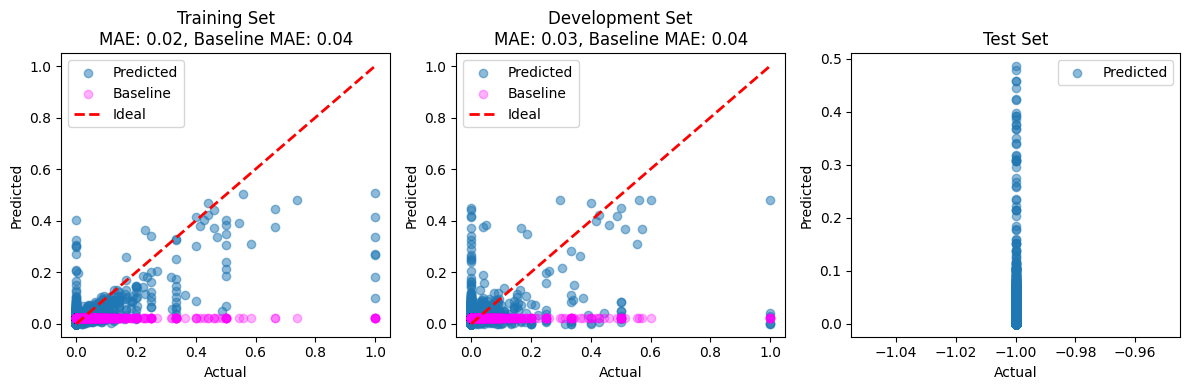

In [45]:
# Plot the results as y_true vs y_pred scatterplots
plt.figure(figsize=(12, 4))

# Training set plot
plt.subplot(1, 3, 1)
plt.scatter(Y_train, Y_train_pred, alpha=0.5, label='Predicted')
plt.scatter(Y_train, Y_train_baseline_pred, alpha=0.3, color='magenta', label='Baseline')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Training Set\n{metric_name}: {train_perf:.2f}, Baseline {metric_name}: {baseline_train_perf:.2f}")
plt.legend()

# Development set plot
plt.subplot(1, 3, 2)
plt.scatter(Y_dev, Y_dev_pred, alpha=0.5, label='Predicted')
plt.scatter(Y_dev, Y_dev_baseline_pred, alpha=0.3, color='magenta', label='Baseline')
plt.plot([Y_dev.min(), Y_dev.max()], [Y_dev.min(), Y_dev.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Development Set\n{metric_name}: {dev_perf:.2f}, Baseline {metric_name}: {baseline_dev_perf:.2f}")
plt.legend()

# Test set plot
plt.subplot(1, 3, 3)
plt.scatter(Y_test, Y_test_pred, alpha=0.5, label='Predicted')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test Set")
plt.legend()

plt.tight_layout()

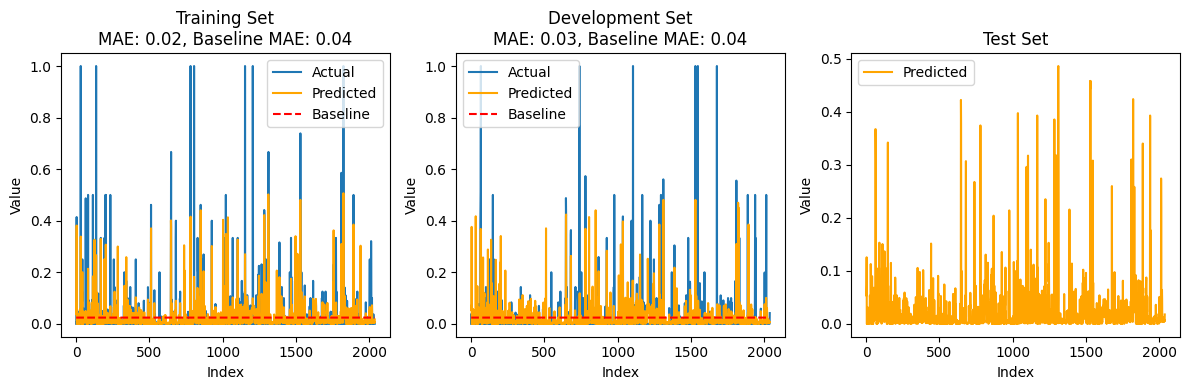

In [46]:
# Plotting the results as overlayed lineplots
plt.figure(figsize=(12, 4))

# Training set plot
plt.subplot(1, 3, 1)
plt.plot(np.array(Y_train), label="Actual")
plt.plot(np.array(Y_train_pred), label="Predicted", color='orange')
plt.plot(np.array(Y_train_baseline_pred), 'r--', label="Baseline")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Training Set\n{metric_name}: {train_perf:.2f}, Baseline {metric_name}: {baseline_train_perf:.2f}")
plt.legend()

# Development set plot
plt.subplot(1, 3, 2)
plt.plot(np.array(Y_dev), label="Actual")
plt.plot(np.array(Y_dev_pred), label="Predicted", color='orange')
plt.plot(np.array(Y_dev_baseline_pred), 'r--', label="Baseline")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Development Set\n{metric_name}: {dev_perf:.2f}, Baseline {metric_name}: {baseline_dev_perf:.2f}")
plt.legend()

# Test set plot
plt.subplot(1, 3, 3)
plt.plot(np.array(Y_test_pred), label="Predicted", color='orange')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Test Set")
plt.legend()

plt.tight_layout()

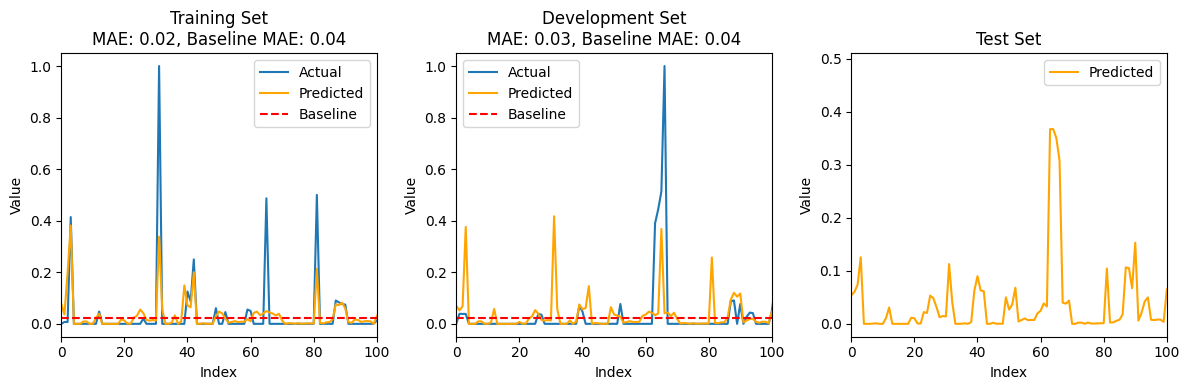

In [47]:
# Zoom in into the lineplots above (index = [0, 100])
plt.figure(figsize=(12, 4))

# Training set plot
plt.subplot(1, 3, 1)
plt.plot(np.array(Y_train), label="Actual")
plt.plot(np.array(Y_train_pred), label="Predicted", color='orange')
plt.plot(np.array(Y_train_baseline_pred), 'r--', label="Baseline")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Training Set\n{metric_name}: {train_perf:.2f}, Baseline {metric_name}: {baseline_train_perf:.2f}")
plt.legend()
plt.xlim(0, 100)  # Zooming in on the x-axis to the range [0-100]

# Development set plot
plt.subplot(1, 3, 2)
plt.plot(np.array(Y_dev), label="Actual")
plt.plot(np.array(Y_dev_pred), label="Predicted", color='orange')
plt.plot(np.array(Y_dev_baseline_pred), 'r--', label="Baseline")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Development Set\n{metric_name}: {dev_perf:.2f}, Baseline {metric_name}: {baseline_dev_perf:.2f}")
plt.legend()
plt.xlim(0, 100)  # Zooming in on the x-axis to the range [0-100]

# Test set plot
plt.subplot(1, 3, 3)
plt.plot(np.array(Y_test_pred), label="Predicted", color='orange')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"Test Set")
plt.legend()
plt.xlim(0, 100)  # Zooming in on the x-axis to the range [0-100]

plt.tight_layout()

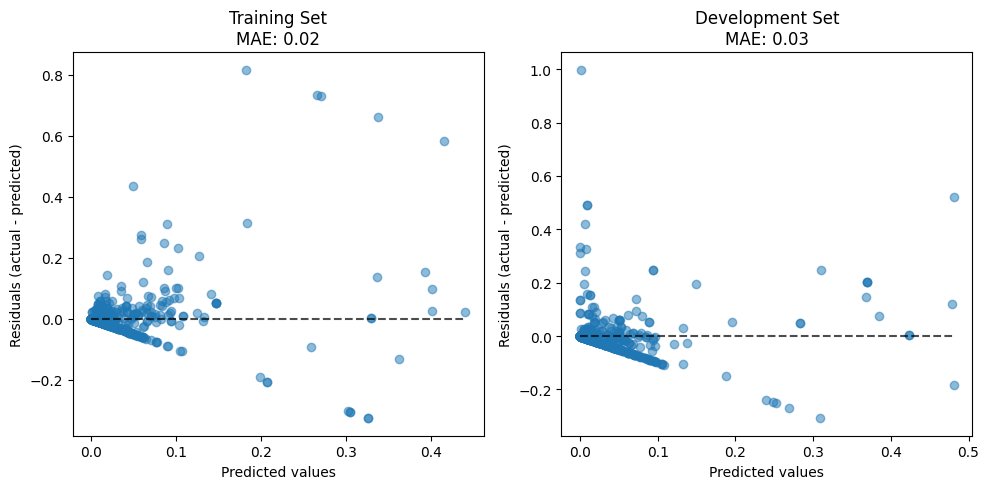

In [48]:
# Examine the prediction residuals against the predicted values using PredictionErrorDisplay
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
PredictionErrorDisplay.from_predictions(Y_train.values.squeeze(), Y_train_pred, ax=axs[0], scatter_kwargs={'alpha':0.5})
axs[0].set_title(f"Training Set\n{metric_name}: {train_perf:.2f}")

PredictionErrorDisplay.from_predictions(Y_dev.values.squeeze(), Y_dev_pred, ax=axs[1], scatter_kwargs={'alpha':0.5})
axs[1].set_title(f"Development Set\n{metric_name}: {dev_perf:.2f}")

plt.tight_layout()

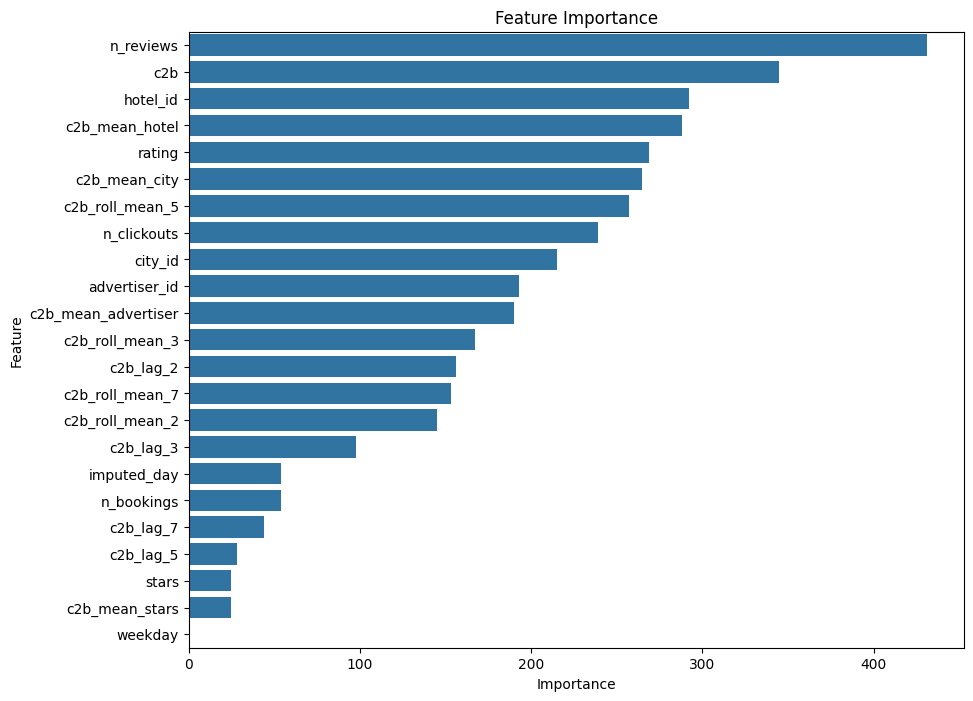

Feature Importance:
                Feature  Importance
5             n_reviews         431
9                   c2b         345
0              hotel_id         292
19       c2b_mean_hotel         288
4                rating         269
21        c2b_mean_city         265
17      c2b_roll_mean_5         257
6           n_clickouts         239
2               city_id         215
1         advertiser_id         193
20  c2b_mean_advertiser         190
16      c2b_roll_mean_3         167
11            c2b_lag_2         156
18      c2b_roll_mean_7         153
15      c2b_roll_mean_2         145
12            c2b_lag_3          98
8           imputed_day          54
7            n_bookings          54
14            c2b_lag_7          44
13            c2b_lag_5          28
3                 stars          25
22       c2b_mean_stars          25
10              weekday           0


In [49]:
# Get feature importance from the best model
"""Split Importance: Each time a feature is used to split a node in a tree, it contributes to reducing the loss function (e.g., mean squared error in regression tasks). The importance of a feature is computed as the total gain across all splits where the feature is used. This gain measures how much using the feature at that point improves the model."""
best_lgb_model = best_model.base_regressor

# Extract feature importance
importance = best_lgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

# Print the DataFrame to check the ranked feature importance
print("Feature Importance:")
print(importance_df)

### Save the Results

In [50]:
# Create DataFrames for actual and predicted values with corresponding ids
Y_train_df = pd.DataFrame({
    'ymd': ymd_X_train.values,
    'hotel_id': X_train['hotel_id'].values,
    'advertiser_id': X_train['advertiser_id'].values,
    'actual': Y_train.squeeze(),
    'predicted': Y_train_pred.squeeze(),
})

Y_dev_df = pd.DataFrame({
    'ymd': ymd_X_dev.values,
    'hotel_id': X_dev['hotel_id'].values,
    'advertiser_id': X_dev['advertiser_id'].values,
    'actual': Y_dev.squeeze(),
    'predicted': Y_dev_pred.squeeze(),
})

Y_test_df = pd.DataFrame({
    'ymd': ymd_X_test.values,
    'hotel_id': X_test['hotel_id'].values,
    'advertiser_id': X_test['advertiser_id'].values,
    'predicted': Y_test_pred.squeeze(),
})

In [51]:
# Save the DataFrames to CSV files
print(f"Saving results to {working_dir}")
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Y_train_df.to_csv(os.path.join(working_dir, f"train_predictions_{timestamp}.csv"), index=False)
# Y_dev_df.to_csv(os.path.join(working_dir, f"dev_predictions_{timestamp}.csv"), index=False)
Y_test_df.to_csv(os.path.join(working_dir, f"test_predictions_{timestamp}.csv"), index=False)

Saving results to D:/Documenti/Projects/2024/trivago_c2b/
